# FairPut - A Methodology for Fair Machine Learning Outputs 

#### **LICENSE**

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

**DISCLAIMER**: This notebook is not legal compliance advice.



### Introduction

FairPut is a light framework that describes a preferred process at the end of the machine learning pipeline to enchance model fairness. This is a holistic approach to obtain less biased outputs at the individual and group level. Developers and researchers first follow the normal table processing, table exploration, feature processing, feature extraction, and model validation steps to obtain the **best possible model** to maximise a certain metric like sales or profit. The FairPut methodology follows on from this initial process. The aim is to simultaneously enhance model interpretability, robustness, and fairness while maintaining a reasonable level of accuracy. FairPut unifies various recent machine learning constructs in a practical manner. This method is model agnostic, but this particular development instance uses LightGBM.

1.	##### **Model Explainability**
  *	Model Respecification 
        1. Protected Values Prediction
        1. Model Constraints
        1. Hyperparameter Modelling
        1. Interpretable Model
        1. Global Explanations
        1. Monotonicity Feature Explanations
  *	Quantitative Validation 
        1. Level Two Monotonicity
        1. Relationship Analysis
        1. Partial Dependence (LV1) Monotonicity
        1. Feature Interactions
        1. Metrics and Cut-off
1.	##### **Model Robustness**
  *	Residual Deviation
  *	Residual Explanations
  *	Benchmark Competition
  *	Adversarial Attack

1.	##### **Regulatory Fairness**
  *	Group
        1. Disparate Error Analysis
            * Parity Indicators
            * Fair Lending Measures
        1. Model Agnostic Processing
            * Reweighing Preprocessing
            * Disparate Impact Preprocessing
            * Calibrate Equalized Odds
        1. Feature Decomposition
  *	Individual
        1. Reasoning
            * Individual Disparity
            * Reasoning Codes

        1. Example Base
            * Prototypical
            * Counterfactual
            * Contrastive


The FairPut model also includes the development of a range of novel methods to help with machine learning development.

Roadmap Contributions:

1. Method to identify model performance using only protected values.
1. Shapley explanations for outlier detection.
1. Non-linear to linear feature transformation.
1. Novel definition of level one and level two monotonicity.
1. Develop two unique quantitative measures of monotonicity: sortedness and proportionality.
1. Train-Test set leakage detection.
1. Anonymous synthetic data generation for tabular data. 
1. Standardised Report Summary of Adjustments and Outputs.
1. Allow for alternative analysis by adjusting Z control parameters.
1. Quantitative Measures for Explainability, Robustness, and Fairness.



## Before FairPut

**Data Description - Default Prediction**

The Home Mortgage Disclosure Act in the US was enacted in congress in 1975. As per the statute, lending institutions are required to report public lending data. In this example, we will look at a sample of consumer-anonymized loans from the HDMA database. These loans are a subset of all originated mortgage loans in the 2018 HMDA data that were chosen to represent a relatively comparable group of consumer mortgages. The data in its preprocessed form comes from a [paper](https://www.mdpi.com/2078-2489/11/3/137) by Gill, Hall, Montgomergy and Schmidt. To a large extent this notebook has been influenced by influenced by this paper and peripheral work of the authors. 

A range of features were selected from this database to predict whether an applicant will default on their loan. The price of the loan is used as a proxy of default. We have thus manufactured a ficticious prediction problem out of real data. A high priced loan for the period is defined as being charged an APR of 150 basis points. After the author's processed the data a range of features and a binary outcome remains. Lenders would naturally look at more features than those produced in this study, but some of the more important features have been included like loan amount, property value, customer income, and LTV, and FTI ratios. The training set contains around 160k loans and the test set just below 40k loans. The data has been stanadardised to make it comparable accross models. The entire economic value comes down to around $50 billion. 


The data also include protected class characteristics and has information on each borrower and co-borrower’s race, ethnicity, gender, and age. Due to the nature of this information, certain measures that can be indicative of discrimination in lending can be calculated directly using the HDMA data. The HMDA data represent one of the most comprehensive source of data on highly-regulated Information 2020 that is publicly available, which makes it an ideal dataset to use for the types of methodological development.

**Software Imports**

*Install Requirements*

In [3]:
!pip install pandasvault

*System Imports*

You can download/copy the folder [here](https://drive.google.com/drive/folders/1oi_BxYwc8O4MiRudTE5LN9YLs46XV0eP?usp=sharing), and point the links to your drive. 

In [4]:
from google.colab import drive
import sys
drive.mount('/content/drive',force_remount=True)
%cd "/content/drive/My Drive/FirmAI/FairPut/"


ModuleNotFoundError: No module named 'google.colab'

In [5]:
import sys
sys.path.append('/content/drive/My Drive/FirmAI/FairPut/scripts')

In [6]:
%reload_ext autoreload
%autoreload 2

*Library Imports*

In [7]:
import pandas as pd
import pandasvault as pv
import numpy as np
import utilities as ut
from sklearn.metrics import roc_auc_score


ModuleNotFoundError: No module named 'utilities'

**Data Preparation**

In [8]:
def load_frame(test_or_train="train"):
  try:
    df = pd.read_csv("data/input/"+test_or_train+".csv",index_col=0)
  except:
    df = pd.read_csv("https://github.com/firmai/random-assets-two/blob/master/fairput/"+test_or_train+".csv?raw=true",index_col=0)
  df = pv.reduce_mem_usage(df)
  df.index = df.index.rename("id")
  df.columns =  [tra.replace('_std', '') for tra in df.columns]
  df = df.rename(columns={"agegte62":"above62","agelt62":"below62","high_priced":"default"})
  #df = ut.auto_category(df)
  if test_or_train=="train":
    del df["cv_fold"]
  return df

In [9]:
train = load_frame("train")
test = load_frame("test")
test_org = test.copy()

Memory usage of dataframe is 28.29 MB
Memory usage after optimization is: 8.10 MB
Decreased by 71.4%
Memory usage of dataframe is 6.69 MB
Memory usage after optimization is: 1.97 MB
Decreased by 70.6%


In [10]:
y, target = 'default','default'
sensitive = ["asian",'black',"white","amind","hipac","hispanic","non_hispanic","male","female",'above62', 'below62']
X = [name for name in train.columns if name not in [y] + sensitive]

print('y =', y)
print('X =', X)

y = default
X = ['term_360', 'conforming', 'debt_to_income_ratio_missing', 'loan_amount', 'loan_to_value_ratio', 'no_intro_rate_period', 'intro_rate_period', 'property_value', 'income', 'debt_to_income_ratio']


For additional information in understanding how the features were developed, please see this [script](https://drive.google.com/open?id=1J3UBEHJ56yQktUbZMSozw6tDD8UWzg8o) from the authors. The data has been specifically processes to suit the needs of this excercise. Generally things get a lot more complex than this example would lead one to believe. One person can belong to many protected categories for example. This dataset excluded people with joint ethnicities, or with two or more minority races as it complicates a fairness analysis of this sort. 

The abbreviations of the above catgories correspond to the following: American Indian is ```amind```; Native Hawaiian or Other Pacific Islander is ```hipac```. A specific question in the mortgage dataset have also singled out hispanic and non-hispanics. 


**Modelling**

Aim for the best performance; this code block is just illustrative in purpuse. It specifically ignores hyperparameter tuning beyond the number of estimators (num_boost_round). Insert your own methodology here; you can for example employ a full hyperparameter tuning operation as is done in future section. The out of sample performance of our *best* performing model is ≈ 83% AUC. We need demographical data to ensure that there is no bias.

In [0]:
import lightgbm as lgb

df_train = train.sample(frac=0.7,random_state=1)
df_valid = train[~train.isin(df_train)].dropna()

params = {'metric': 'auc',
          'objective': 'binary',
          'random_seed': 1}

d_train = lgb.Dataset(df_train[X], label=df_train[y])
d_valid = lgb.Dataset(df_valid[X], label=df_valid[y])
print("Validation Performance:")
model_val = lgb.train(params, d_train, valid_sets=[d_valid], early_stopping_rounds=500, verbose_eval=1000)

print("Test Performance:")
y_pred_test = model_val.predict(test[X])
print('ROC AUC {}'.format(roc_auc_score(test[y], y_pred_test)))
## Difference with previous sans demographic score is negligible: ROC AUC 0.8275

Validation Performance:
Training until validation scores don't improve for 500 rounds.
Did not meet early stopping. Best iteration is:
[45]	valid_0's auc: 0.834882
Test Performance:
ROC AUC 0.8275999747261114


In an attempt to measure the full performance of the model, the remaining training data ```df_valid``` should be inlcuded in the full set of data with the newly identified parameters. So we can resort back to ```train``` that includes all the observations. The performance of this model, will be our final performance ceiling. This score should always be higher if the underlying distribution of the data is the same. More data is better for most learning models under such assumption.

In [0]:
d_train = lgb.Dataset(train[X], label=train[y])
model_f = lgb.train(params, d_train )

print("Test Performance:")
y_pred_test = model_f.predict(test[X])
print('ROC AUC {}'.format(roc_auc_score(test[y], y_pred_test)))

Test Performance:
ROC AUC 0.8287089323145733


## FairPut Method

At the point where you have developed your best performing model, the FairPut method takes over. The reason we first develop the best possible model is so that we have a benchmark to compare explainable, robust, and fair models against. The first FairPut step is to identify a more explainable model. In this example, a LightGBM model perfomed best on our tabular data, and happens to be a model that can be made more interpretable by adjusting model parameters. The next section identifies the steps to ahieve a greater level of interpretability for gradient boosting models. 

## Step 1 - Explainable

#### **Model Respecification**

**Protected Values Prediction**

One of the first questions we have to ask is whether our model prima facie suffers from social bias. To measure this we can predict the outcome of default by purely using protected values as features. The model includes the following attributes as features 
```'asian',
 'black',
 'white',
 'amind',
 'hipac',
 'hispanic',
 'non_hispanic',
 'male',
 'female',
 'above62',
 'below62'```

In [0]:
d_train = lgb.Dataset(train[sensitive], label=train[y])
model_f = lgb.train(params, d_train )

print("Test Performance:")
y_pred_test = model_f.predict(test_org[sensitive])
print('ROC AUC {}'.format(roc_auc_score(test_org[y], y_pred_test)))

Test Performance:
ROC AUC 0.6542773680128373


Because we are able to predict the default of a mortgage above average (0.5) using only protected (senstive) features, we can confirm that we have a socially biased model at the group level. Because the model predicts default, a loan would not be extended to these applicants. The main idea with bias mitigation is to discourage differences between protected and privileged categories, regardless of underlying difference in group circumstance. It is an equitable and compassionate policy that could reinvigorate a previously disadvantaged group. Immediate effects could translate to a privlidged group losing more advantages as well as short term profit decreases at the company level. These effects can be mitigated by applying a blanket rule to all companies, which would protect against non-compliant companies surviving due to short term profits as opposed to compliant companies. Equity doctrines could invigorate previously disadvantaged groups and could have substantial long-term economic benefits by getting them out of negative feedback loops.

**Model Constraints**

To identify the reasons as to why certain groups or people are disadvantaged over others, we will create a monotononically constrained model based on target correlations. Although manyresearchers blindly constraint models to target correlations, this can be dangerous. It is better to have a theoretical model to explain why correlations exist, for that reason, we will investigate all absolute correlations of 5% and up with the target variable and investigate any theoretical inconsitencies. 

The ```monotonic constraint``` is necessary when advising users on the reasons for the decision operation. On top of monotonic constraints another constraint called ```feature sampeling``` is commended. Feature sampling helps to discourage collinear patterns from overemphasisng one correlated feature over another. This value will be constrained at 50%. These hyperparameters would be fixed, but other parameters would be allowed to float freely, and would be selected on using hyperparameter tuning methods. Blanket monotonic constraint would inhibit the model from achieving its full performance, however, each variable appearing in your reason codes should be monotonically constrained. The existence of model monotonicity can be confirmed with experiment.  

Monotone Variable Description

In [0]:
# Calculate correlation
numeric_corr_y = pd.DataFrame(train[X + [y]].corr()[y]).iloc[:-1]
numeric_corr_y = numeric_corr_y[numeric_corr_y[y].abs() > 0.05]; numeric_corr_y.sort_values(y,ascending=False)

,default
debt_to_income_ratio,0.128649
loan_to_value_ratio,0.111554
conforming,0.074543
term_360,0.052448
loan_amount,-0.123546
property_value,-0.137319


Lets first survey the strongest correlations that make theoretical sense. The ```debt-to-income ratio``` and ```loan-to-value ratio``` makes directional sense. The larger ```loan amounts``` probably accounts for unseen borrower attributes like disposable income and wealth. Also a person with a larger loan has more bargaining power and can shop for the best loan rates (i.e., cheaper loans) leading to a lower risk of default the same goes for a ```property with higher value```. Where the loan ```terms is 360 months``` as opposed to 180 months, there is a higher risk of default. More can go wrong in 360 months, and it could also assume that if you have the capacity to service your loan in 180 months, you have a stable and well paying job or are a high net worth individual all else equal.

A conforming loan's relationship to the target variable is tricky and does not make sense at first. A conforming loan is a mortgage of which the value is equal to or less than the dollar amount established by the limit set by the Federal Housing Finance Agency (FHFA) and the loan limit is the size of the mortgage that Freddie Mac and Fannie Mae will purchase and gaurantee. For some reason this shows a positive relationship, this could be due to the fact that people with non-conforming loans might have attributes such that they make for good borrowers, this is further investigated in the next code block. 

Conforming Correlation

In [0]:
# Calculate Attribute Correlations with Conforming
numeric_corr = pd.DataFrame(train[X + [y]].corr()["conforming"]).iloc[:-1]
numeric_corr = numeric_corr[numeric_corr['conforming'].abs() > 0.05]; numeric_corr

,conforming
conforming,1.000000
loan_amount,-0.680444
loan_to_value_ratio,0.076088
no_intro_rate_period,0.298602
intro_rate_period,-0.259901
property_value,-0.652648
debt_to_income_ratio,0.080123


**(1)** There is a strong positive correlation between non-confirming loans and the size of the loan. This relationship could be attributed to "jumbo loans" that have picked up in recent years. One of the reasons why non-confirming loans are less likely to default than conforming loans is the increase in guarantee fees (also known as g-fees) for the loans bought by Fannie Mae and Freddie Mac for conforming and high-balance conforming loans. The average g-fee has almost tripled since 2010 from 22 basis points to 57 basis points in 2017 (Figure 2). Since jumbo loans are too big to be purchased by Fannie Mae and Freddie Mac, those fees have little or no impact on the note rate of the jumbo loans. Fannie Mae and Freddie Mac are pricing the credit risk of conforming loans, while banks are pricing the credit risk of jumbo loans. Thus, increase in guarantee fees has the effect of raising interest rates for conforming loans with little or no impact on the mortgage rates for jumbo loans. **(2)** Another reason is the comparatively higher credit standard of jumbo loans. The credit risk characteristics of jumbo loans have evolved overtime. However, this does nto seem to hold out as they still have worse financial ratios than conforming loans. **(3)** Lastly, because we are not controlling for size or any other variable for that matter, and the fact that larger borrowers could shop for more lenient rates, could also have an affect. The ```conforming``` variable can clearly go both ways and would be highly non-linear, and for that reason, I won't comment on its monotonicity as it is prone to change, and I won't force the model to hold ths directional relationship. For that reason, we will have to investigate PDs and ICE plots to concur the directional relationships of other variables that will be used for explanation purposes and reason codes.

In [0]:
def monotone(df, X, y, columns=[]):
  cors = df[X + [y]].corr()[y]
  mono_constraints = list([0 if col not in columns else int(i) for i, col in zip(np.sign(cors.values[:-1]),cors.iloc[:-1].index.to_list())])
  mono_dict = {col:sign for col, sign in zip(cors.iloc[:-1].index.to_list(), mono_constraints)}
  mono_str = ','.join(map(str, mono_constraints))
  return mono_str, mono_dict
  
constrained = numeric_corr_y.index.to_list()
constrained.remove("conforming")
mono_str, _ = monotone(train, X, y, constrained); print(mono_str)
_, mono_direction_dict = monotone(train, X, y, X)

1,0,0,-1,1,0,0,-1,0,1


**Hyperparameter Modelling**

In [0]:
from functools import partial
from hyperopt import fmin, hp, tpe, Trials, space_eval
from sklearn.model_selection import cross_val_score

In [0]:
# #>>>> For Hyperparameter Tuning I will Switch the GPU on (30-40% speed benefit)
# #>>>>(1) Turn GPU on (2) Select 'Yes' after running, (3) Restart Environment Once (4) Skip This Execution after the res.

# ## Code for LightGBM GPU if you need some additional speed for hyperoptimisation
# !pip uninstall lightgbm
# !git clone --recursive https://github.com/microsoft/LightGBM
# %cd /content/LightGBM
# !mkdir build
# !cmake -DUSE_GPU=1 #avoid ..
# !make -j$(nproc)
# !sudo apt-get -y install python-pip
# !sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
# %cd /content/LightGBM/python-package
# !python setup.py install --precompile

# ### Additional
# !pip uninstall pandas
# !pip install pandas
# !pip install scikit-learn==0.21.3

In [0]:
# from lightgbm import LGBMClassifier


# # Only need to run this once, it would take about 3-4 hours, and then you can save your parameters.
# # Define search space
# hyper_space = {'n_estimators': 1000 + hp.randint('n_estimators', 10500),
#                'max_depth':  hp.choice('max_depth', [4, 5, 8, -1]),
#                'num_leaves': hp.choice('num_leaves', [10, 15, 31, 127]),
#                'subsample': hp.uniform('subsample', 0.6, 1.0),
#                 "monotone_constraints": mono_str, """-> Imposing monotonic constraint."""
#                 "bagging_fraction":0.5,   """-> Imposing feature sample constraint."""
#                 "bagging_seed":1, 
#                 "random_seed":1, ## doesn't seem to have an effect
#                 #"max_bin": 255,
#                 "learning_rate": 0.05, 
#                 "boosting_type": "gbdt",
#                 #"device": "gpu",
#                 "objective": "binary",
#                 "metric": "auc",
#                 "verbose": -1,
#                 "min_data": 100,
#                 "boost_from_average": True,
#                }

# def evaluate(params, X, y):

#     # Initilize instance of estimator
#     est = LGBMClassifier(n_jobs=-1, random_state=1) # n_jobs=-1 maximise usage

#     # Set params
#     est.set_params(**params)

#     # Calc CV score
#     scores = cross_val_score(estimator=est, X=X, y=y,
#                              scoring='r2', cv=4)
#     score = np.mean(scores)

#     return score

# # Objective minizmied
# hyperopt_objective = lambda params: (-1.0) * evaluate(params, train[X], train[y])

# # Trail
# trials = Trials()

# # Set algoritm parameters
# algo = partial(tpe.suggest,
#                n_startup_jobs=20, gamma=0.25, n_EI_candidates=24)

# # Fit Tree Parzen Estimator
# best_vals = fmin(hyperopt_objective, space=hyper_space,
#                  algo=algo, max_evals=60, trials=trials,
#                  rstate=np.random.RandomState(seed=2018))

# # Print best parameters
# best_params = space_eval(hyper_space, best_vals)
# print("BEST PARAMETERS: " + str(best_params))

# # Print best CV score
# scores = [-trial['result']['loss'] for trial in trials.trials]
# print("BEST CV SCORE: " + str(np.max(scores)))

# # Print execution time
# tdiff = trials.trials[-1]['book_time'] - trials.trials[0]['book_time']
# print("ELAPSED TIME: " + str(tdiff.total_seconds() / 60))

# # Set params
# est.set_params(**best_params)

*Best Parameters Static Save*

In [0]:
## Obtained from above hyperparameter tuning 
best_params = {'bagging_fraction': 0.5,
 'bagging_seed': 1,
 'boost_from_average': True,
 'boosting_type': 'gbdt',
 'device': 'cpu',
 #'device': 'gpu',
 'learning_rate': 0.05,
 'max_bin': 255,
 'max_depth': 4,
 'metric': 'auc',
 'min_data': 100,
 'monotone_constraints': mono_str,
 'n_estimators': 234,
 'num_leaves': 15,
 'objective': 'binary',
 'random_seed': 1,
 'subsample': 0.7507111215719215,
 'verbose': -1} 

**Interpretable Model**

In [0]:
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")

auc_perf = {}
d_train = lgb.Dataset(train[X], label=train[y])
d_test = lgb.Dataset(test[X], label=test[y])
model = lgb.train(best_params, d_train, verbose_eval=1000)
y_pred_test = model.predict(test[X])
perf = roc_auc_score(test[y], y_pred_test)
auc_perf["half-mono"] = perf
print('ROC AUC {}'.format(perf))

ROC AUC 0.8142107147766557


As a result of the monotonic constraints and 50% feature sampling, there is a 2 percentage point drop in the AUC. Pure monotonicity lead to a 3 percentage point decrease. The above model would be the one we use, below is just a comparison between alternative models that can be selected, but would not be theoretically sound.

In [0]:
new_params = best_params.copy()
mono_str_full, _ = monotone(train, X, y, X_sens); mono_str
new_params["monotone_constraints"] = mono_str_full
full_mono_model = lgb.train(new_params, d_train, verbose_eval=1000)
y_pred_test = full_mono_model.predict(test[X])
perf = roc_auc_score(test[y], y_pred_test)
auc_perf["full-mono"] = perf
print('Full Mono ROC AUC {}'.format(perf))

mono_str_none, _  = monotone(train, X, y); mono_str
new_params["monotone_constraints"] = mono_str_none
no_mono_model = lgb.train(new_params, d_train, verbose_eval=1000)
y_pred_test = no_mono_model.predict(test[X_sens])
perf = roc_auc_score(test[y], y_pred_test)
auc_perf["no-mono"] = perf
print('No Mono ROC AUC {}'.format(perf))

Full Mono ROC AUC 0.7963959205204965
No Mono ROC AUC 0.8282718649327339


In [0]:
!pip install shap

     |████████████████████████████████| 276kB 1.4MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394113 sha256=ce2169f2498ea6aa2e58ab55072d32dad0991b6be17fbd90ffa6e87ce95943cc
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


**Interpretable Global Explanations**

In [0]:
import shap

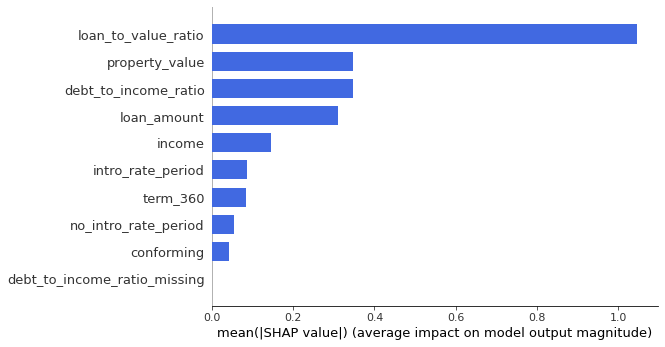

In [0]:
# shap_values is Numpy array
shap_values = model.predict(test[X], pred_contrib=True)

shap_values_plot_abs = shap_values[:,:-1]
shap.summary_plot(shap_values_plot_abs, X, plot_type='bar', color='royalblue')

In [0]:
 ### Fair to ABS then SUM or MEAN
shap_abs_mean = pd.DataFrame(shap_values_plot_abs, columns=list(X))
shap_abs_mean = shap_abs_mean.abs().mean().sort_values(ascending=False).to_frame()
shap_abs_mean.columns = ["SHAP Values"]; shap_abs_mean

,SHAP Values
loan_to_value_ratio,1.045981
property_value,0.347968
debt_to_income_ratio,0.346992
loan_amount,0.309823
income,0.144495
intro_rate_period,0.085487
term_360,0.084430
no_intro_rate_period,0.054857
conforming,0.041242
debt_to_income_ratio_missing,0.000000


**Level Two Monotonicity Feature Explanations**

We want to ensure that the values that would appear in our reason codes (all model constrained variables) are monotonic. One might first wonder why they won't be given that they have been constrained. The reasons is that they are still allowed to interact with other variables that are not monotonically constrained. So here we want to ensure that a reasonble level of monotonicity is maintained. We will first do it visually and then quantitatively. The SHAP value on the x-axis is the change in log-odds, this value is used because of its additive properties, and because it is able to have negative values. For a binary classification task, the value can be converted between a zero and one using a formula as follows for any given row, ```logistic(sum(all local contributions) + mean(yhat)) = model prediction```. The first model we will look at is the model with constraints on ```debt_to_income_ratio```, 	 ```loan_to_value_ratio``` ,	```conforming``` , ```term_360``` 	, ```loan_amount``` and ```property_value``` variables. This is our preferred, more theoretically sound model.

*Half-Mono (Our Model)*

Visually, the values of import ```debt_to_income_ratio```, 	 ```loan_to_value_ratio``` ,	```conforming``` , ```term_360``` 	, ```loan_amount``` and ```property_value``` seems to be reasonably monotonic. The montonicity is guaged by looking at the gradual warming or cooling of colouring, without too many dots of anomalous discoloration from left to right or right to left. The only value showing some questionable behaviour is the ```loan_to_value_ratio```. Nonwitstanding the above, I am still impressed with the model's mostly gradual movement from high to low values

In [1]:

# plot Shapley variable importance summary 
shap.summary_plot(shap_values[:, :-1], test[X])

NameError: name 'shap' is not defined

*No-Mono Model*

The reason for the above constraints become clear when looking at the ```loan_to_value_ratio``` here we can see a lot more discolouration on opposite sides of the zero. To eximplify the problem, the blue dot on the right is a person seeking a loan. How are we going to explain to this loan seeker that them having a lower loan to value ratio (normally a good sign), has partly attributed to them defaulting. If income was one of the reason code (correlation stronger than 5% with target), then it would also have posed a problem.

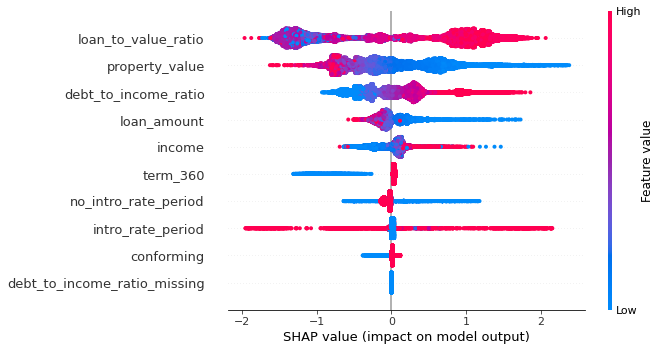

In [0]:
# shap_values is Numpy array
shap_values = no_mono_model.predict(test[X], pred_contrib=True)
# plot Shapley variable importance summary 
shap.summary_plot(shap_values[:, :-1], test[X])

*Full-Mono (Potential Model)*

By trading off additional predictive power an even more constrained and gradual model can be achieved. 

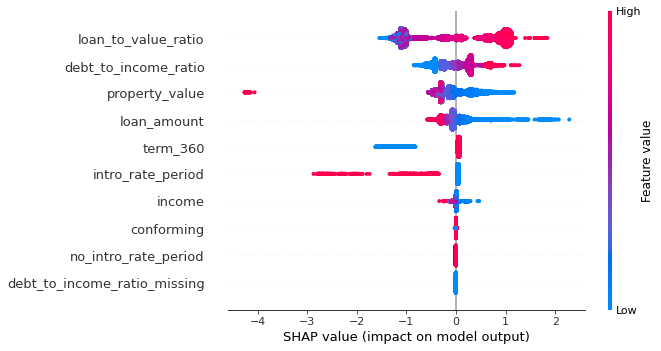

In [0]:
# shap_values is Numpy array
shap_values = full_mono_model.predict(test[X], pred_contrib=True)
# plot Shapley variable importance summary 
shap.summary_plot(shap_values[:, :-1], test[X])

Full mono gives some distorted relationships, half-mono mostly conserves the expected relationships without distortion. I would argue that the half-mono at 5% correlation gives the best model for the purposed of interpretability. Intro-rate-period and others will have to take on a non-linear explanation. A further exposition of this non-linear relationship follows. 

#### **Quantitative Validation**

**Level Two Monotonicity**

Here we will be studying two novel measures of monotonicity, the first is called sortedness, and the second proportionality. We will purely work with the reason code (5%+ correlation with target). Level one monotonicity promises that when the value of a feature increases all else kept equal, the output of the model increases in one direction. Level two monotonicity promises that when the value of a value increases with all other variables allowed to vary, the output of the model increases in one direction. Level two monotonicity is close to impossible, for that reason, we measure the extent of level two monotonicity. Two level two monotonicity measures developed here are sortedness and propotionality.

In [0]:
import math 
## Sample Size Calculation

input_row = len(train) 
sampled = min(1, (1/math.log(input_row, 3))*np.exp((2/math.log(input_row, 10000000)))/20)
sample_size = int(input_row*sampled)

increase_size = 3 
efficient_size = int(input_row*sampled*sampled) * increase_size
print("Efficient Sample Size: " + str(efficient_size))

## Quantitative Monotonicity Function 
## All variables  mono_direction_dict
## Taking predicted output should give you very similar results. 
def quant_mono(modeller, df, mono_direction_dict):
  explainer = shap.TreeExplainer(modeller)
  shap_values = explainer.shap_values(df)
  values = pd.DataFrame(shap_values[0], columns=[ft+"_shap" for ft in df.columns], index= df.index)
  values = pd.concat((values,df ),axis=1)

  m_sort_dict = {}
  m_prop_dict = {}
  m_perc_prop_dict = {}
  m_perc_sort_dict = {}

  df_mono = {}
  df_mono["sample"] = {}
  df_mono["df"] = {}
  for col in mono_direction_dict.keys():
    values_drop = values[values[col+ "_shap"]!=0].copy()

    #Method possible but less comparable, by shap value would make more sense. 
    #You want to remove what one might call obvious values
    values_drop = values_drop.sort_values(col + "_shap")
    values_drop["drop"] = values_drop[col].diff()
    values_drop = values_drop[values_drop["drop"]!=0]
    print(col +" samples : " + str(len(values_drop)))

    #one_percent_grace = values_drop[col].mean()/100

    if mono_direction_dict[col]>0:
      m_sort_dict[col] = np.abs(values_drop.sort_values(col + "_shap",ascending=False)[col].values - values_drop.sort_values(col)[col].values).mean()
      #m_prop_dict[col] = np.where(np.diff(values_drop.sort_values(col + "_shap")[col].values) <= 0 ,0, 1).sum()/len(values_drop) #divide by original
    else:
      m_sort_dict[col] = np.abs(values_drop.sort_values(col + "_shap")[col].values - values_drop.sort_values(col)[col].values).mean()
      #m_prop_dict[col] = np.where(np.diff(values_drop.sort_values(col + "_shap")[col].values) >= 0 ,0, 1).sum()/len(values_drop) #divide by original

    cuts = 100 
    counter_order = np.array([bel for bel in range(cuts) for tel in range(int(len(values_drop)/cuts)+1) ])[:len(values_drop)]
    values_drop = values_drop.sort_values(col + "_shap").reset_index(drop=True)
    values_drop["counter_order"] = counter_order
    values_gg = values_drop.groupby("counter_order").mean().reset_index()

    if len(values_drop)>int(len(values)*0.01):

      if mono_direction_dict[col]>0:
        m_perc_sort_dict[col] = np.abs(values_gg[col].values - values_gg.sort_values(col,ascending=False)[col].values).mean()
        m_perc_prop_dict[col] = np.where(np.diff(values_gg.sort_values(col + "_shap")[col].values) <= 0 ,0, 1).sum()/len(values_gg)
      else:
        m_perc_sort_dict[col] = np.abs(values_gg[col].values - values_gg.sort_values(col)[col].values).mean()
        m_perc_prop_dict[col] = np.where(np.diff(values_gg.sort_values(col + "_shap")[col].values) >= 0 ,0, 1).sum()/len(values_gg)
    else:
        m_perc_sort_dict[col] = 0
        m_perc_prop_dict[col] = 0

    df_mono["sample"][col] = len(values_drop)
    df_mono["df"][col] = values_gg
    
  return m_sort_dict, m_perc_prop_dict, m_perc_sort_dict, df_mono


Efficient Sample Size: 2190


What does the holistic montonotonicity (**sortedness**) look like studying effect size. (The size of monotonic conflicts)

In [0]:
mono_dict = {}
mono_dict["sortedness"] = {}
mono_dict["perc_sort"] = {}
mono_dict["proportion"] = {}
mono_dict["perc_prop"] = {}

(mono_dict["sortedness"]["half-mono"],
mono_dict["proportion"]["half-mono"],
mono_dict["perc_sort"]["half-mono"], mono_half_df_dict)     = quant_mono(model, train[X][:efficient_size], mono_direction_dict)
(mono_dict["sortedness"]["full-mono"],
mono_dict["proportion"]["full-mono"],
 mono_dict["perc_sort"]["full-mono"], mono_full_df_dict)     = quant_mono(full_mono_model, train[X][:efficient_size], mono_direction_dict)
(mono_dict["sortedness"]["no-mono"],
mono_dict["proportion"]["no-mono"],
 mono_dict["perc_sort"]["no-mono"], mono_no_df_dict)     = quant_mono(no_mono_model, train[X][:efficient_size], mono_direction_dict)

mono_sort = pd.DataFrame.from_dict(mono_dict["sortedness"])
mono_sort = mono_sort[mono_sort.index.isin(constrained)]; mono_sort

term_360 samples : 2
conforming samples : 4
debt_to_income_ratio_missing samples : 0
loan_amount samples : 1718
loan_to_value_ratio samples : 1751
no_intro_rate_period samples : 2
intro_rate_period samples : 37
property_value samples : 1550
income samples : 2119
debt_to_income_ratio samples : 939
term_360 samples : 2
conforming samples : 2
debt_to_income_ratio_missing samples : 0
loan_amount samples : 1466
loan_to_value_ratio samples : 1510
no_intro_rate_period samples : 0
intro_rate_period samples : 81
property_value samples : 1413
income samples : 2047
debt_to_income_ratio samples : 799
term_360 samples : 2
conforming samples : 2
debt_to_income_ratio_missing samples : 0
loan_amount samples : 1889
loan_to_value_ratio samples : 1810
no_intro_rate_period samples : 17
intro_rate_period samples : 73
property_value samples : 1759
income samples : 2133
debt_to_income_ratio samples : 1217


,half-mono,full-mono,no-mono
term_360,0.000000,0.000000,0.000000
loan_amount,0.263428,0.307617,0.401123
loan_to_value_ratio,0.229980,0.277588,0.383789
property_value,0.295410,0.547363,0.319336
debt_to_income_ratio,0.213867,0.264160,0.287109


**Sortedness** like above but with percentile cuts (Less Noise)

In [0]:
mono_sort = pd.DataFrame.from_dict(mono_dict["perc_sort"])  
mono_sort = mono_sort[mono_sort.index.isin(constrained)]; mono_sort

,half-mono,full-mono,no-mono
term_360,0.000000,0.000000,0.000000
loan_amount,0.054901,0.104919,0.100037
loan_to_value_ratio,0.068359,0.071960,0.132202
property_value,0.107422,0.326660,0.092773
debt_to_income_ratio,0.031860,0.063965,0.073486


What **proportion** of the consecutive values are higher than the previous value. (The proportion of monotonic conflicts)

In [0]:
# The lower the better 
mono_prop = pd.DataFrame.from_dict(mono_dict["proportion"])
mono_prop = mono_prop[mono_prop.index.isin(constrained)]; mono_prop

,half-mono,full-mono,no-mono
term_360,0.000000,0.000000,0.000000
loan_amount,0.260417,0.387755,0.350000
loan_to_value_ratio,0.336735,0.336842,0.489583
property_value,0.257732,0.315789,0.336735
debt_to_income_ratio,0.319149,0.360000,0.372340


Why does it seem that half-mono gives the best monotonicity, it seems that full monotonicity constraints impacts property value and debt-to-income ratios negatively. Because full-mono constraints all other non-reason codes, it seems to be affecting the core feature values. This gives us further evidence that half_mono would be the preferred method. All methods treat term-360 the same, this can be confirmed by looking at the gradual change in the colouring. The metrics obtained here corrosponds to the coloured visualisation. Note the variables have all been standardised before this analysis.

**Relationship** Analysis

*Correlation*

In [0]:
feat= "loan_to_value_ratio"
abs(mono_half_df_dict["df"][feat].sort_values(feat+"_shap")[[feat,feat+"_shap"]].corr().iloc[0,1])

0.9210994223663612

*Line Plot*

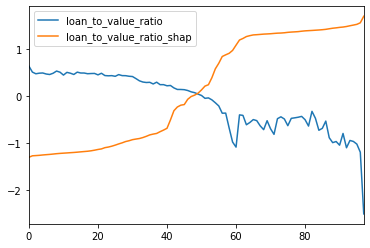

In [0]:
mono_half_df_dict["df"][feat].sort_values(feat+"_shap")[[feat,feat+"_shap"]].plot()

*Scatter Plot*

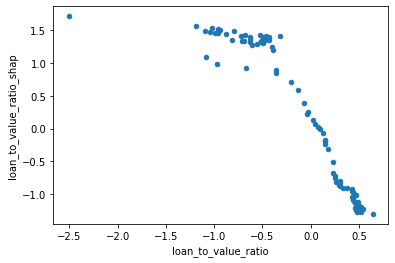

In [0]:
mono_half_df_dict["df"][feat].sort_values(feat+"_shap").plot.scatter(x=feat, y=feat+"_shap")

*Combined Effect*

In [0]:
all_prop = pd.DataFrame.from_dict(mono_dict["proportion"]) ; all_prop

,half-mono,full-mono,no-mono
term_360,0.000000,0.000000,0.000000
conforming,0.000000,0.000000,0.000000
debt_to_income_ratio_missing,0.000000,0.000000,0.000000
loan_amount,0.260417,0.387755,0.350000
loan_to_value_ratio,0.336735,0.336842,0.489583
no_intro_rate_period,0.000000,0.000000,0.000000
intro_rate_period,0.405405,0.469136,0.493151
property_value,0.257732,0.315789,0.336735
income,0.597938,0.387755,0.597938
debt_to_income_ratio,0.319149,0.360000,0.372340


In [0]:
all_sort = pd.DataFrame.from_dict(mono_dict["perc_sort"]) ; all_sort

,half-mono,full-mono,no-mono
term_360,0.000000,0.000000,0.000000
conforming,0.000000,0.000000,0.000000
debt_to_income_ratio_missing,0.000000,0.000000,0.000000
loan_amount,0.054901,0.104919,0.100037
loan_to_value_ratio,0.068359,0.071960,0.132202
no_intro_rate_period,0.000000,0.000000,0.000000
intro_rate_period,2.429688,1.473633,2.384766
property_value,0.107422,0.326660,0.092773
income,0.043518,0.003519,0.040924
debt_to_income_ratio,0.031860,0.063965,0.073486


Lets us have a look at the effect size times the proportion per person affected. Answers the question of what feature has the potential to result in the most montonic injustice per person.

In [0]:
combined = all_prop * all_sort.values; combined

,half-mono,full-mono,no-mono
term_360,0.000000,0.000000,0.000000
conforming,0.000000,0.000000,0.000000
debt_to_income_ratio_missing,0.000000,0.000000,0.000000
loan_amount,0.014297,0.040683,0.035013
loan_to_value_ratio,0.023019,0.024239,0.064724
no_intro_rate_period,0.000000,0.000000,0.000000
intro_rate_period,0.985008,0.691334,1.176049
property_value,0.027686,0.103156,0.031240
income,0.026021,0.001365,0.024470
debt_to_income_ratio,0.010168,0.023027,0.027362


*Level 2 Monotonic Injustice Percentage*

Lets Look at the effect size times the proportion per the entire sample observed. Answers the question, what features could lead to the the most possible monotonic injustices measured in quantity and size. You can think of this as the percentage of people that might face a monotonic injustic as a result of this feature.

In [0]:
dfs = [pd.DataFrame.from_dict(df["sample"],orient="index") for df in [mono_half_df_dict, mono_full_df_dict, mono_no_df_dict]]

In [0]:
model_effect = combined * pd.concat(dfs,axis=1).values/efficient_size*100; model_effect

,half-mono,full-mono,no-mono
term_360,0.000000,0.000000,0.000000
conforming,0.000000,0.000000,0.000000
debt_to_income_ratio_missing,0.000000,0.000000,0.000000
loan_amount,1.121577,2.723349,3.020055
loan_to_value_ratio,1.840467,1.671295,5.349333
no_intro_rate_period,0.000000,0.000000,0.000000
intro_rate_period,1.664170,2.556988,3.920163
property_value,1.959515,6.655671,2.509188
income,2.517751,0.127543,2.383317
debt_to_income_ratio,0.435979,0.840130,1.520524


In [0]:
mont = model_effect.mean()/model_effect.mean().max()

In [0]:
di_p = pd.DataFrame.from_dict(auc_perf,orient="index")
no =  100 # inverse importance of performance
half = no + (auc_perf["no-mono"] - auc_perf["half-mono"])*100
full = no + (auc_perf["no-mono"] - auc_perf["full-mono"])*100
di_p[0] = [half, full, no]
di_p = di_p/di_p.max()

Performance to Explainability Measure

In [0]:
di_p[0]/mont

half-mono    1.926702
full-mono    1.283198
no-mono      0.969109
dtype: float64

**Partial Dependence Monotonicity** (Less Strict Level 1 Monotonicity Measure)

In [0]:
### I am going to use my own, but I will switch off residuals, it should be as easy as that. 

def par_dep(xs, frame, model, y=None, resid=False, abs_=False, resolution=20,
            bins=None):
    
    """ Calculates partial dependence and residuals of partial dependence.

    Args:
        xs: Variable for which to calculate partial dependence or its residuals.
        frame: Pandas DataFrame for which to calculate partial dependence or 
               its residuals.
        model: XGBoost model for which to calculate partial dependence or 
               its residuals.
        y: Name of original target variable.   
        resid: Return residuals of partial dependence instead of partial 
               dependence, default False.
        abs_: Return unsigned, absolute residuals, default False.
              (Good for handling both classes in logloss simultaneously.)
        resolution: The number of points across the domain of xs for which 
                    to calculate partial dependence or its residuals, default 20.
        bins: List of values at which to set xs, default 20 equally-spaced 
              points between column minimum and maximum.
    
    Returns: Pandas DataFrame containing partial dependence or its residual 
             values at bins.
        
    """
    
    # turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None
    
    # # initialize empty Pandas DataFrame with correct column names
    # return_frame = pd.DataFrame(columns=[xs,'residual'])
    
    # cache original column values 
    col_cache = frame.loc[:, xs].copy(deep=True)
  
    # determine values at which to calculate partial dependence
    if bins is None:
        min_ = frame[xs].min()
        max_ = frame[xs].max()
        by = (max_ - min_)/resolution
        # modify max and by 
        # to preserve resolution and actually search up to max
        bins = np.arange(min_, (max_ + by), (by + np.round((1. / resolution) * by, 3)))


    # residuals of partial dependence
    if resid:        
        
        # initialize empty Pandas DataFrame with correct column names
        return_frame = pd.DataFrame(columns=[xs,'residual'])
        
        for j in bins:

            # frame to cache intermediate results
            rframe_ = pd.DataFrame(columns=['actual', 'pred',  'res'])

            frame.loc[:, xs] = j 
            # reset index for expected merge behavior
            rframe_['actual'] = frame[y].reset_index(drop=True)
            rframe_['pred'] = pd.DataFrame(model.predict(frame))
            # logloss residual
            rframe_['res'] = -rframe_['actual']*np.log(rframe_['pred']) -\
                             (1 - rframe_['actual'])*np.log(1 - rframe_['pred'])

            if abs_:
                # optionally return absolute value
                resid_j = np.abs(rframe_['res']).mean() 
            else:
                resid_j = rframe_['res'].mean()

            del rframe_            

            return_frame = return_frame.append({xs:j,
                                               'residual': resid_j}, 
                                               ignore_index=True)
            
    # partial dependence  
    else:   
        
      return_frame = pd.DataFrame(columns=[xs, 'partial_dependence'])
      # determine values at which to calculate partial dependence

      # calculate partial dependence  
      # by setting column of interest to constant 
      # and scoring the altered data and taking the mean of the predictions
      for j in bins:
          frame.loc[:, xs] = j
          par_dep_i = pd.DataFrame(model.predict(frame))
          par_dep_j = par_dep_i.mean()[0]
          return_frame = return_frame.append({xs:j,
                                                'partial_dependence': par_dep_j}, 
                                                ignore_index=True)
          
    # return input frame to original cached state    
    frame.loc[:, xs] = col_cache

    return return_frame

def plot_par_dep_ICE_comb(xs, par_dep_frame, ax=None, ticks=None, labels=None):

    
    """ Plots ICE overlayed onto partial dependence for a single variable.
    Conditionally uses user-defined axes, ticks, and labels for grouped subplots.
    
    Args: 
        xs: Name of variable for which to plot ICE and partial dependence.
        par_dep_frame: Name of Pandas DataFrame containing ICE and partial
                       dependence values.
        ax: Matplotlib axis object to use, default None.         
        ticks: List of numeric x-axis tick marks, default None.  
        labels: List of string values to use as the visual label for ticks, 
                default None. 
    
    """
    
    # initialize figure and axis for grouped subplots 
    if (ticks is None) & (labels is None) & (ax is None):
        pass
    else:
        _ = ax.set(xticks=ticks, xticklabels=labels) # user-defined 
    
    # for standalone plotting
    if ax is None:
        
        # initialize figure and axis
        fig, ax = plt.subplots()
        
        # plot ICE
        par_dep_frame.drop('partial_dependence', axis=1).plot(x=xs, 
                                                              colormap='coolwarm', 
                                                              ax=ax)
        # overlay partial dependence, annotate plot
        par_dep_frame.plot(title='Partial Dependence with ICE',
                           x=xs, 
                           y='partial_dependence',
                           color='grey', 
                           linewidth=3, 
                           ax=ax)
    
    # for grouped subplots 
    else: 
        
        # plot ICE
        par_dep_frame.drop('partial_dependence', axis=1).plot(x=xs, 
                                                              colormap='coolwarm',
                                                              ax=ax)
        # overlay partial dependence, annotate plot
        par_dep_frame.plot(title='Partial Dependence with ICE',
                           x=xs, 
                           y='partial_dependence',
                           color='grey', 
                           linewidth=3, 
                           ax=ax)

    # add legend
    _ = plt.legend(bbox_to_anchor=(1.05, 0),
                   loc=3, 
                   borderaxespad=0.)


def get_percentile_dict(yhat,  frame):

    """ Returns the percentiles of a column, yhat, as the indices based on 
        another column id_.
    
    Args:
        yhat: Column in which to find percentiles.
        id_: Id column that stores indices for percentiles of yhat.
        frame: Pandas DataFrame containing yhat and id_. 
    
    Returns:
        Dictionary of percentile values and index column values.
    
    """
    
    # create a copy of frame and sort it by yhat
    sort_df = frame.copy(deep=True)
    sort_df.sort_values(yhat, inplace=True)
    
    # find top and bottom percentiles
    percentiles_dict = {}
    percentiles_dict[0] = sort_df.index[0]
    percentiles_dict[99] = sort_df.index[-1]

    # find 10th-90th percentiles
    inc = sort_df.shape[0]//10
    for i in range(1, 10):
        percentiles_dict[i * 10] = sort_df.index[i * inc] 

    return percentiles_dict

You might be better off removing outliers with this analysis. The data is already standardised, so you can just choose your deviation cut-off, I will be using 5 standard deviations.

In [0]:
#PDPs
# You can essentially do the same for ice..
# but it would be a very expensive operation
list_frames = []
dict_pdp = {}
for feat in X:
  train_out = train[X].copy()
  train_out = train_out[(train_out[feat]>-5)&(train_out[feat]<5)]
  pardep_df = par_dep(feat, train_out, model) 
  dict_pdp[feat] = pardep_df.copy()
  pardep_df.columns = ["None",feat]
  list_frames.append(pardep_df[[feat]])

In [0]:
all_pds = pd.concat(list_frames,axis=1).ffill()

In [0]:
all_pds.head()

,term_360,conforming,debt_to_income_ratio_missing,loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,debt_to_income_ratio
0,0.047989,0.087354,0.096688,0.359789,0.018137,0.10394,0.095250,0.143046,0.093761,0.044550
1,0.097568,0.097252,0.096688,0.172220,0.018137,0.10394,0.096009,0.135337,0.126766,0.044550
2,0.097568,0.097252,0.096688,0.107246,0.018137,0.10394,0.096009,0.093575,0.214445,0.044550
3,0.097568,0.097252,0.096688,0.082715,0.018365,0.10394,0.096009,0.071565,0.214445,0.053516
4,0.097568,0.097252,0.096688,0.064434,0.018439,0.10394,0.095906,0.058600,0.214445,0.053516


In [0]:
pdp_dict= {}
for col in mono_direction_dict.keys():
  if mono_direction_dict[col]<0:
    pdp_dict[col] = np.where(np.diff(all_pds[col].values) <= 0 ,0, 1).sum()/len(all_pds)
  else:
    pdp_dict[col] = np.where(np.diff(all_pds[col].values) >= 0 ,0, 1).sum()/len(all_pds)

In [0]:
mono_direction_dict.keys()

dict_keys(['term_360', 'conforming', 'debt_to_income_ratio_missing', 'loan_amount', 'loan_to_value_ratio', 'no_intro_rate_period', 'intro_rate_period', 'property_value', 'income', 'debt_to_income_ratio'])

**Divergence** from Lv1 Monotonicty

In [0]:
pd.DataFrame.from_dict(pdp_dict,orient="index")

,0
term_360,0.000000
conforming,0.000000
debt_to_income_ratio_missing,0.000000
loan_amount,0.000000
loan_to_value_ratio,0.000000
no_intro_rate_period,0.047619
intro_rate_period,0.142857
property_value,0.000000
income,0.095238
debt_to_income_ratio,0.000000


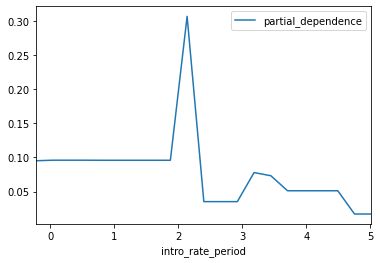

In [0]:
feat = "intro_rate_period"
df_p = dict_pdp[feat]
df_p.plot.line(x=feat, y='partial_dependence')

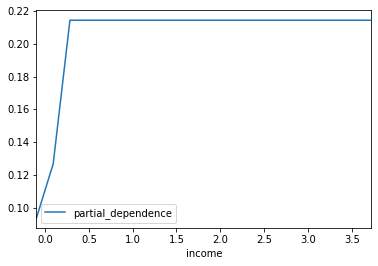

In [0]:
feat = "income"
df_p = dict_pdp[feat]
df_p.plot.line(x=feat, y='partial_dependence')

In [0]:
#ICEs
## Break down into prediction percentile splits
y_pred = model.predict(train_out)
y_hat = "pred"
train_out[y_hat] = y_pred
perc_dict = get_percentile_dict(y_hat, train_out)
del train_out[y_hat]
bins = list(pardep_df[feat])
for i in sorted(perc_dict.keys()):
    col_name = 'Percentile_' + str(i)
    pardep_df[col_name] = par_dep(feat, 
                                            train_out[train_out.index == int(perc_dict[i])], 
                                            model,bins=bins)['partial_dependence']


In [0]:
pardep_df.head()

,loan_to_value_ratio,partial_dependence,Percentile_0,Percentile_10,Percentile_20,Percentile_30,Percentile_40,Percentile_50,Percentile_60,Percentile_70,Percentile_80,Percentile_90,Percentile_99
0,-2.498047,0.018176,0.000251,0.003160,0.005474,0.013373,0.008921,0.007396,0.010531,0.019444,0.011082,0.023735,0.628768
1,-2.237219,0.018320,0.000276,0.003562,0.006168,0.013373,0.008921,0.007396,0.010531,0.019444,0.011082,0.023735,0.628768
2,-1.976391,0.018320,0.000276,0.003562,0.006168,0.013373,0.008921,0.007396,0.010531,0.019444,0.011082,0.023735,0.628768
3,-1.715562,0.018393,0.000276,0.003562,0.006168,0.013373,0.008921,0.007396,0.010531,0.019444,0.011082,0.023735,0.628768
4,-1.454734,0.018393,0.000276,0.003562,0.006168,0.013373,0.008921,0.007396,0.010531,0.019444,0.011082,0.023735,0.628768


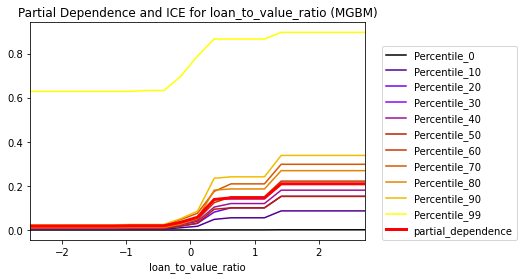

In [0]:
import matplotlib.pyplot as plt

feat = "loan_to_value_ratio"
fig, ax = plt.subplots()
pardep_df.drop('partial_dependence', axis=1).plot(x=feat, colormap='gnuplot', ax=ax)

pardep_df.plot(title='Partial Dependence and ICE for {} (MGBM)'.format(feat),
                         x=feat, 
                         y='partial_dependence',
                         style='r-', 
                         linewidth=3, 
                         ax=ax)

_ = plt.legend(bbox_to_anchor=(1.05, 0),
               loc=3, 
               borderaxespad=0.)

In [0]:
!pip install pdpbox

     |████████████████████████████████| 57.7MB 52kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690722 sha256=882dde7fe84e51b7802191ec41a5143d0174d096fa89fae654db64147c2c2f10
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


Here we can see there is non-monotonicity level one in the data, we don't want to model to have this

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


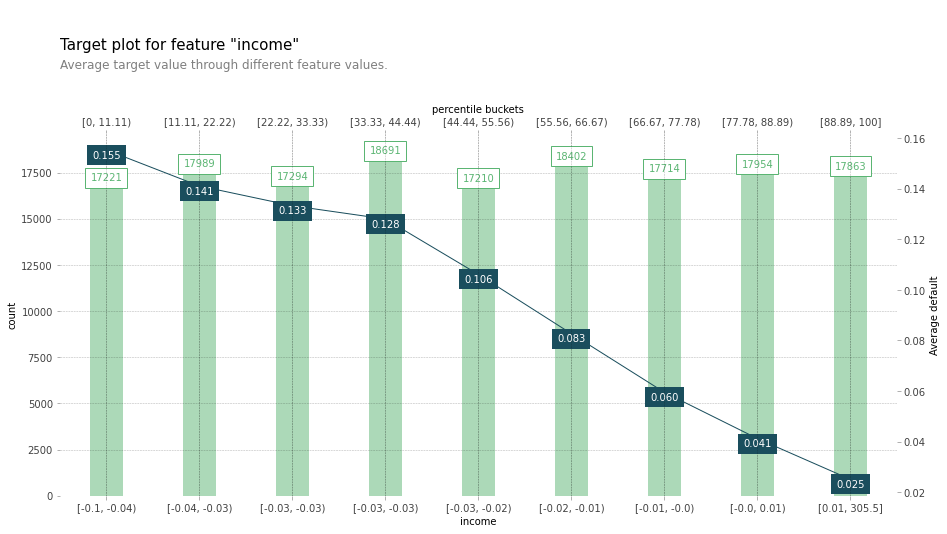

In [0]:
from pdpbox import pdp, get_dataset, info_plots

fig, axes, summary_df = info_plots.target_plot(
    df=train, feature=feat, feature_name=feat, target=y, show_percentile=True
)

In [0]:
summary_df

,x,display_column,value_lower,value_upper,percentile_column,percentile_lower,percentile_upper,count,default
0,0,"[-0.1, -0.04)",-0.097839,-0.038239,"[0, 11.11)",0.00,11.11,17221,0.155396
1,1,"[-0.04, -0.03)",-0.038239,-0.034058,"[11.11, 22.22)",11.11,22.22,17989,0.141113
2,2,"[-0.03, -0.03)",-0.034058,-0.030258,"[22.22, 33.33)",22.22,33.33,17294,0.133301
3,3,"[-0.03, -0.03)",-0.030258,-0.025757,"[33.33, 44.44)",33.33,44.44,18691,0.128052
4,4,"[-0.03, -0.02)",-0.025757,-0.020905,"[44.44, 55.56)",44.44,55.56,17210,0.106140
5,5,"[-0.02, -0.01)",-0.020905,-0.014320,"[55.56, 66.67)",55.56,66.67,18402,0.082703
6,6,"[-0.01, -0.0)",-0.014320,-0.004967,"[66.67, 77.78)",66.67,77.78,17714,0.059509
7,7,"[-0.0, 0.01)",-0.004967,0.013741,"[77.78, 88.89)",77.78,88.89,17954,0.041229
8,8,"[0.01, 305.5]",0.013741,305.500000,"[88.89, 100]",88.89,100.00,17863,0.025085


In [0]:
from lightgbm import LGBMClassifier

est = LGBMClassifier(n_jobs=-1, random_state=1) # n_jobs=-1 maximise usage
est.set_params(**best_params)
model_sk = est.fit(train[X],train[y])


And here the model mostly fixes the non-monotonicty. The small drop in the third candel stick is negligible and not worth imposing the full mono-model. Look at the next chart to see why it is negligible

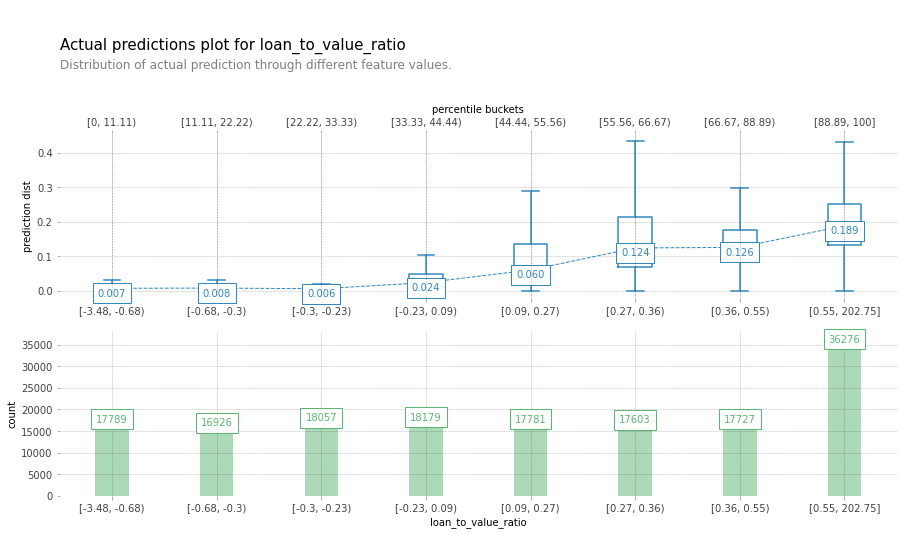

In [0]:
fig, axes, summary_df = info_plots.actual_plot(
    model=model_sk, X=train[X], feature=feat, feature_name=feat, 
    show_percentile=True, predict_kwds={}
)

In [0]:
pdp_iso = pdp.pdp_isolate(
    model=model_sk, dataset=train_out, model_features=X, feature=feat, predict_kwds={}
)

**Single Feature Investigation**

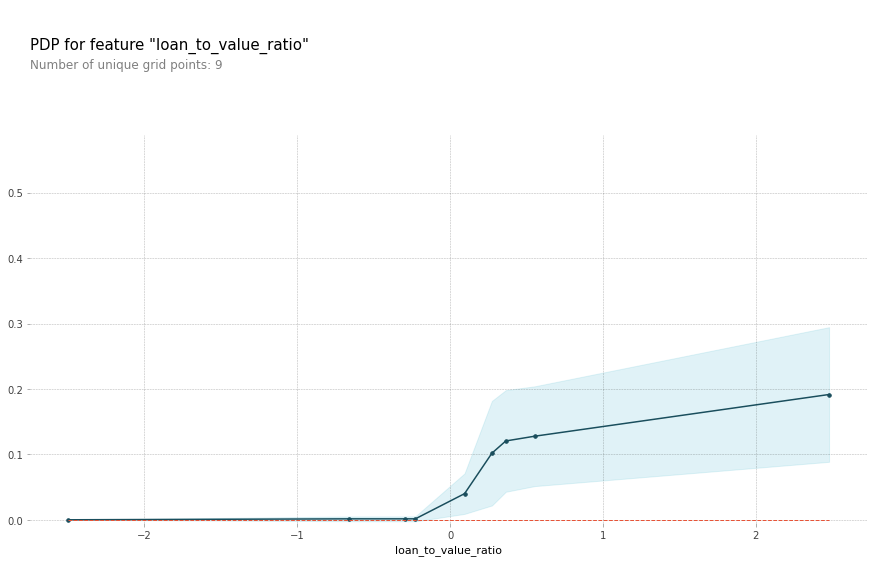

In [0]:
fig, axes = pdp.pdp_plot(pdp_iso, feat)

The partial dependence plot for the average effect of a feature is a global method because it does not focus on specific instances, but on an overall average. The equivalent to a PDP for individual data instances is called individual conditional expectation (ICE) plot. A PDP is the average of the lines of an ICE plot. The ice plot comes closer to the concept of level two monotonicty, why do some instances react stronger to the same feature value change than others? Is this reaction justified. ICE plots provide more insight into interactions, like the shapley value method. Although visually appealing, the individual ICE method doesn't allow for a nice emperical study on level monotonicity. 

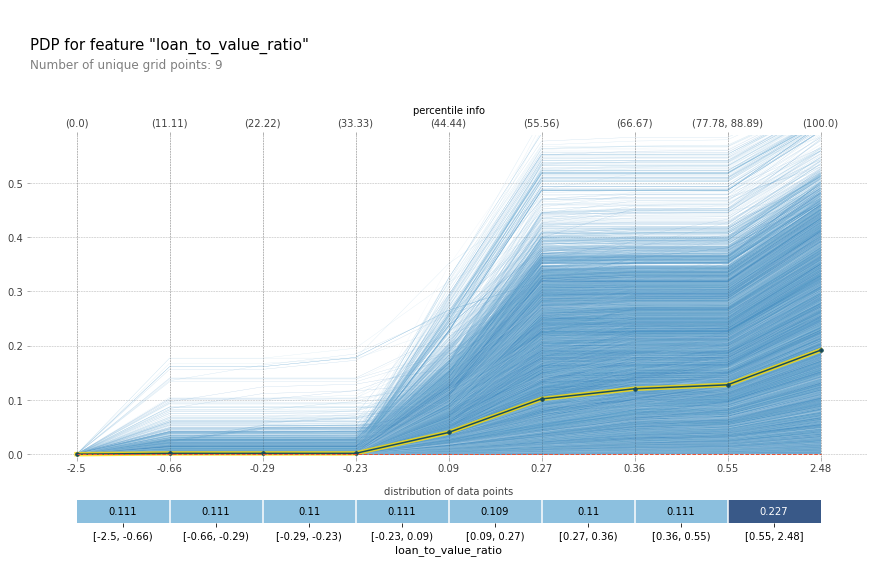

In [0]:
fig, axes = pdp.pdp_plot(
    pdp_iso, feat, frac_to_plot=0.5, plot_lines=True, x_quantile=True, show_percentile=True, plot_pts_dist=True
)

**Feature Interaction**
- This continues with our half-mono model
- Here I am explaining the model's interactions on the training set
- You can also look at the test set, or both sets combined, it should give you very similar results.

Here we build a Shapely tree explainer using a small sample of observations. We construct the variable ```inter``` that primarily looks at feature interactions.

In [0]:
import math 

is_true = False
inter_portion = 0.8

explainer = shap.TreeExplainer(model)
inter = shap.TreeExplainer(model).shap_interaction_values(train[X][:sample_size].values)

Efficient Sample Size: 2190


Take the mean absolute value and list the strongest interacting pairs, the goal which is to explain above non-linear relationships (features for which the colour patterns change, are scattered, or are not gradual). The hope is that we would come to understand why the features behave as they do as an additional robustness step.

In [0]:
df_start = pd.DataFrame(np.abs(np.mean(inter ,axis=0)),columns=X, index=X)

#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
sol = (df_start.where(np.triu(np.ones(df_start.shape), k=1).astype(np.bool))
                .stack().sort_values(ascending=is_true))
                
iter_pairs = sol[sol.cumsum().sub((sol.sum()*inter_portion)).le(0)]

list_one = [da[0] for da in iter_pairs.index]
list_two = [da[1] for da in iter_pairs.index]

From the outcome below, it is clear that the largest effect for ```intro_rate_period``` could be playing off against ```loan_to_value_ratio```. Next we would look at that graphically. We can be put at ease due to the fact that this feature doesn't seem to have more than 10-20% effect on the final outcome. Later tests should confirm this, the interaction effects can not be conclusive on that statement. 

In [0]:
iter_pairs

loan_amount           income                  0.038935
loan_to_value_ratio   no_intro_rate_period    0.006792
                      intro_rate_period       0.006114
no_intro_rate_period  intro_rate_period       0.005940
loan_to_value_ratio   debt_to_income_ratio    0.003266
loan_amount           loan_to_value_ratio     0.002612
                      property_value          0.002427
term_360              income                  0.001998
dtype: float64

Dependence Plot for ```intro_rate_period```

The dependence plot shows you how the SHAP values (model output expressed in change in log-odds) varies by feauture value. Note that every dot is a person (application), and the vertical dispersion at a single feature value results from interaction effects in the model. These feature interaction effects are large for values of ```intro_rate_period``` above two. The bottom is the feature and the left hand side is the SHAP value of the feature. The right hand colouring scheme occurs from an automatically selected feature with the highest interaction effects. Like our previous manual step, it has identified, ```loan_to_value_ratio```. Initially what it looks like, is that a high ```intro_rate_period``` with a low ```loan_to_value_ratio``` is good sign, but a high ```intro_rate_period``` with a low ```loan_to_value_ratio``` is a bad sign. To add a level of monotonicity, you could create a ratio between these two variables. This feature should be considered in the next model development itteration.

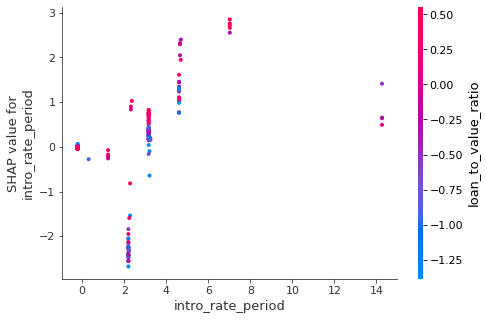

In [0]:
shap.dependence_plot("intro_rate_period", shap_values[0], train[X][:efficient_size])

Lets confirm this relationship with an interaction chart. 

The rows have to be the same, so multiply with sampled twice, also interaction values needed. This again shows that a ratio would have a good effect.

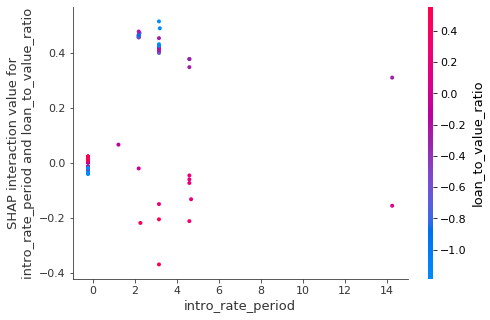

In [0]:
shap.dependence_plot(
    ("intro_rate_period", "loan_to_value_ratio"),
    inter, train[X][:int(input_row*sampled*sampled)],
    display_features=train[X][:int(input_row*sampled*sampled)]
)

Before we move on, lets look if we can spot anything else out of the ordinary from an interaction summary plot. 

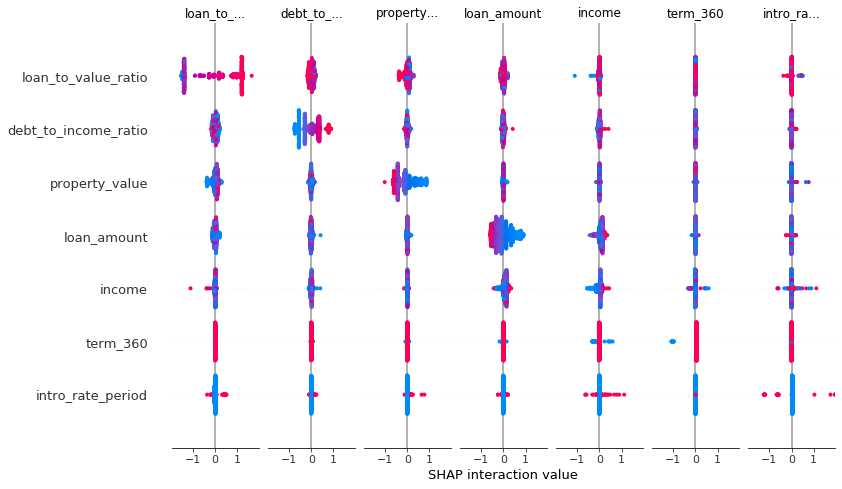

In [0]:
shap.summary_plot(inter, train[X][:int(input_row*sampled*sampled)])

Metrics

In [0]:
preds = model.predict(test[X])
preds_frame = test.copy()
y_hat = y + "_pred"
preds_frame[y_hat] = preds 

def get_prauc(frame, y, yhat, pos=1, neg=0, res=0.01):
    
    """ Calculates precision, recall, and f1 for a pandas dataframe of y and yhat values.
    
    Args:
        frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        y: Name of actual value column.
        yhat: Name of predicted value column.
        pos: Primary target value, default 1.
        neg: Secondary target value, default 0.
        res: Resolution by which to loop through cutoffs, default 0.01.
    
    Returns:
        Pandas dataframe of precision, recall, and f1 values. 
    """
    
    frame_ = frame.copy(deep=True) # don't destroy original data
    dname = 'd_' + str(y) # column for predicted decisions
    eps = 1e-20 # for safe numerical operations
    
    # init p-r roc frame
    prauc_frame = pd.DataFrame(columns=['cutoff', 'recall', 'precision', 'f1'])
    
    # loop through cutoffs to create p-r roc frame
    for cutoff in np.arange(0, 1 + res, res):

        # binarize decision to create confusion matrix values
        frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)
        
        # calculate confusion matrix values
        tp = frame_[(frame_[dname] == pos) & (frame_[y] == pos)].shape[0]
        fp = frame_[(frame_[dname] == pos) & (frame_[y] == neg)].shape[0]
        tn = frame_[(frame_[dname] == neg) & (frame_[y] == neg)].shape[0]
        fn = frame_[(frame_[dname] == neg) & (frame_[y] == pos)].shape[0]
        
        # calculate precision, recall, and f1
        recall = (tp + eps)/((tp + fn) + eps)
        precision = (tp + eps)/((tp + fp) + eps)
        f1 = 2/((1/(recall + eps)) + (1/(precision + eps)))
        
        # add new values to frame
        prauc_frame = prauc_frame.append({'cutoff': cutoff,
                                          'recall': recall,
                                          'precision': precision,
                                          'f1': f1}, 
                                          ignore_index=True)
    
    # housekeeping
    del frame_
    
    return prauc_frame
        
prauc_frame = get_prauc(preds_frame, y, y_hat)

In [0]:
best_cut = prauc_frame.loc[prauc_frame['f1'].idxmax(), 'cutoff'] # Find cutoff w/ max F1
### !!! UNCOMMENT LINES BELOW TO REMEDIATE MINOR FAIRNESS ISSUES !!! ###
# best_cut = 0.3  # min threshold with overall fairness
# best_cut = 0.46 # max accuracy
# best_cut = 0.35 # max MCC
print('%.2f' % best_cut)

0.17


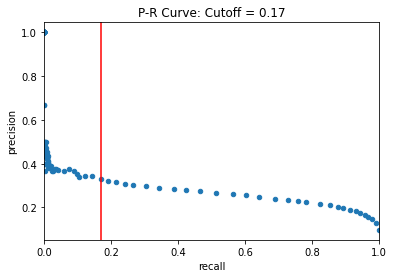

In [0]:
# Plot P-R AUC w/ best cutoff
title_ = 'P-R Curve: Cutoff = ' + str(best_cut)
ax = prauc_frame.plot(x='recall', y='precision', kind='scatter', title=title_, xlim=[0,1])
_ = ax.axvline(best_cut, color='r')

In [0]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

y_pred_prob_lgb = model.predict(test[X])
y_pred_gs_lgb = np.where(y_pred_prob_lgb>best_cut,1,0)

print(classification_report(test[y], y_pred_gs_lgb))

print('Precision is:'+str(round(precision_score(test[y], y_pred_gs_lgb),2)))
print('Recall is:'+str(round(recall_score(test[y], y_pred_gs_lgb, average='binary'),2)))
print('F1 score is:'+str(round(f1_score(test[y], y_pred_gs_lgb, average='binary'),2)))

              precision    recall  f1-score   support

         0.0       0.95      0.81      0.88     35794
         1.0       0.26      0.60      0.36      3868

    accuracy                           0.79     39662
   macro avg       0.60      0.71      0.62     39662
weighted avg       0.88      0.79      0.83     39662

Precision is:0.26
Recall is:0.6
F1 score is:0.36


In [0]:
# pv.classification_scores(test[y], y_pred_gs_lgb, y_pred_prob_lgb)

## Step 2 - Robustness

#### **Residual Deviation**

In [0]:
# merge GBM predictions onto test data
y_hat = y + "_pred"
test_yhat = test.copy()
test_yhat[y_hat] =model.predict(test[X])

# find percentiles of predictions
percentile_dict = get_percentile_dict(y_hat, test_yhat)

# display percentiles dictionary
# ID values for rows
# from lowest prediction 
# to highest prediction
percentile_dict

{0: 5873946,
 10: 5259991,
 20: 4507220,
 30: 784715,
 40: 5245143,
 50: 398019,
 60: 2560540,
 70: 4491201,
 80: 821641,
 90: 5556286,
 99: 1600892}

In [0]:
test_res = test_yhat.copy()
test_res['s'] = 1
test_res.loc[test_res[y] == 0, 's'] = -1
resid_dr = y + "_resdr"
test_res[resid_dr] = test_res['s'] * np.sqrt(-2*(test_res[y]*np.log(test_res[y_hat]) +
                                                                 ((1 - test_res[y])*np.log(1 - test_res[y_hat]))))
test_res = test_res.drop('s', axis=1)

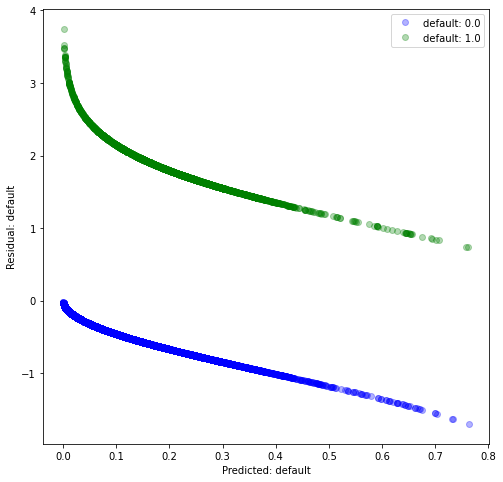

In [0]:
## residual deviance
import matplotlib.pyplot as plt                                   # general plotting
from matplotlib.lines import Line2D                               # necessary for custom legends
import seaborn as sns      

groups = test_res.groupby(y) # define groups
fig, ax_ = plt.subplots(figsize=(8, 8))          # initialize figure

plt.xlabel('Predicted: {}'.format(y))
plt.ylabel('Residual: {}'.format(y))

# plot groups with appropriate color
color_list = ['b', 'g'] 
c_idx = 0
for name, group in groups:
    ax_.plot(group[y_hat], group[resid_dr], label=' '.join(['{}:'.format(y), str(name)]),
             marker='o', linestyle='', color=color_list[c_idx], alpha=0.3)
    c_idx += 1

_ = ax_.legend(loc=1) # legend



In [0]:
test_res.head()

,default,term_360,conforming,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,above62,below62,debt_to_income_ratio_missing,loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,debt_to_income_ratio,default_pred,default_resdr
id,,,,,,,,,,,,,,,,,,,,,,,,
131497,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,NaN,NaN,0.0,-0.470459,0.345215,0.244385,-0.215332,-0.504883,-0.008087,-2.527344,0.092677,-0.441038
851117,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,0.321045,0.342529,-4.089844,3.203125,0.080750,-0.010857,-1.156250,0.028503,-0.240489
835616,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,0.0,1.0,0.0,-0.118652,0.552734,0.244385,-0.215332,-0.289307,-0.016052,1.037109,0.197380,-0.663135
121491,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,-0.646484,-1.192383,0.244385,-0.215332,-0.320068,-0.029221,0.031921,0.006118,-0.110790
4479643,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,0.0,1.0,0.0,0.277100,0.336914,0.244385,-0.215332,0.049927,0.000577,0.763184,0.085876,-0.423767


In [0]:
# shortcut name
resid_ll = y + '_resll' 

# calculate logloss residuals
test_res[resid_ll] = -test_res[y]*np.log(test_res[y_hat]) -\
                       (1 - test_res[y])*np.log(1 - test_yhat[y_hat])   
    
# check that logloss is calculated correctly
# should match eval-logloss above
print('Mean logloss residual: %.6f' % test_res[resid_ll].mean())

Mean logloss residual: 0.259050


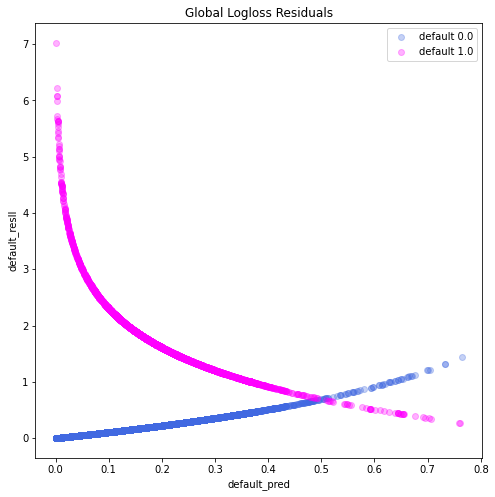

In [0]:
# initialize figure
fig, ax_ = plt.subplots(figsize=(8, 8))         

# plot groups with appropriate color
color_list = ['royalblue', 'magenta'] 
c_idx = 0
groups = test_res.groupby(y) 
for name, group in groups:
    ax_.plot(group[y_hat], group[resid_ll], 
             label=' '.join([y, str(name)]),
             marker='o', linestyle='', color=color_list[c_idx], alpha=0.3)
    c_idx += 1
    
# annotate plot
_ = plt.xlabel(y_hat)
_ = plt.ylabel(resid_ll)
_ = ax_.legend(loc=1)
_ = plt.title('Global Logloss Residuals')

High positive residuals seems to be caused by the model believing that the mortgage won't be defaulted on, but it in fact is. Three values that seem to be particularly low for these individuals is the ```loan_to_value_ratio```, ```debt_to_income_ratio``` and ```term_360``` value. There combined effect seems to confuse the prediction model. At some point we would have to see if we can obtain similar individuals that have indeed remain solvent.

In [0]:
test_resdr = test_res.sort_values(by=resid_dr, ascending=False).reset_index(drop=True)
test_resdr.head(5)

,default,term_360,conforming,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,above62,below62,debt_to_income_ratio_missing,loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,debt_to_income_ratio,default_pred,default_resdr,default_resll
0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,0.0,1.0,0.0,-0.162598,-2.599609,0.244385,-0.215332,2.455078,-0.004967,-1.156250,0.000889,3.748387,7.025201
1,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,-0.426514,-0.988281,0.244385,-0.215332,-0.135132,0.030380,-0.425049,0.001996,3.526014,6.216387
2,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,1.0,0.0,0.936523,-0.275391,0.244385,-0.215332,0.851562,0.012009,-1.156250,0.002286,3.487392,6.080951
3,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,0.0,1.0,0.0,-0.646484,-1.278320,0.244385,-0.215332,-0.289307,-0.009819,-2.527344,0.002287,3.487262,6.080497
4,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,0.0,1.0,0.0,0.848633,-0.249634,0.244385,-0.215332,0.759277,0.059143,-2.527344,0.002497,3.462031,5.992830


#### **Residual Explanations**

FFOOD is a package that I created for outlier identification using residual analysis and shapley explanations. 

In [0]:
!pip install ffood

  Created wheel for ffood: filename=ffood-0.4-cp36-none-any.whl size=3917 sha256=b437c4f2f865bcadfcd87432c95e4277848ab034cb3660675be5ade0cc557220
  Stored in directory: /root/.cache/pip/wheels/cd/9c/86/77e6a4da7d5108684a8fee6f9fdc9204d57bd3925ff7f908ec
Successfully built ffood


In [0]:
train.head()

,default,term_360,conforming,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,above62,below62,debt_to_income_ratio_missing,loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,debt_to_income_ratio
id,,,,,,,,,,,,,,,,,,,,,,
2549300,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,0.0,-0.514160,0.333984,0.244385,-0.215332,-0.536133,-0.040314,0.854492
4000757,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,1.0,0.0,0.0,-0.118652,0.268799,0.244385,-0.215332,-0.227539,-0.018127,-0.425049
1546928,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,-0.778320,0.229004,-4.089844,4.609375,-0.720703,-0.032349,0.123352
5453145,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,0.0,1.0,0.0,-0.074646,-1.150391,0.244385,-0.215332,0.358154,-0.018127,-0.425049
4943130,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,1.0,0.0,-0.602539,0.552734,0.244385,-0.215332,-0.628418,-0.038239,0.763184


Here you can select any feature or target to test prediction outlier observations and explanations for that outliers. 

In [0]:
from ffood import tables

features_to_investigate = [y,"loan_to_value_ratio"]
perc_sample = 0.05
df_sample = train[X + [y]].sample(int(len(train)*perc_sample),random_state=1)
observations, full_feature, chars, shap_val_dict, shap_exp_dict, ind_dict, framed_dict = tables(df_sample, features_to_investigate)

['default', 'loan_to_value_ratio']
Start default (1/2)
First Half
Training Iteration: 1/5
...........
Second Half
Training Iteration: 1/5
success
 
Completed default (1/2)
Start loan_to_value_ratio (2/2)
First Half
Training Iteration: 1/5
...........
Second Half
Training Iteration: 1/5
success
 
Completed loan_to_value_ratio (2/2)


In this analysis we also look for outliers by looking at the features. Application 5111213 was predicted to have a high loan_to_value_ratio. But in reality it was low. Lets try and understand this outlier by looking at the shapley values invidually for that amount in the next code block.

In [0]:
investigate = y
obs = observations[observations["Predicted Feature"]==investigate];obs

,Predicted Feature,Overprediction Index,Overpredict Percentage,Predicted (O),Actual (O),Underprediction Index,Underpredict Percentage,Predicted (U),Actual (U)
0,default,4325410,92,0.923550,0.0,2143088,-84,0.151495,1.0
1,default,5681158,92,0.920335,0.0,4327992,-84,0.156476,1.0
2,default,157230,86,0.866779,0.0,5193624,-83,0.162606,1.0
3,default,1718320,86,0.866123,0.0,5227931,-83,0.163625,1.0
4,default,1338283,83,0.832266,0.0,1861080,-83,0.166587,1.0


In [0]:
framed_dict[investigate].loc[obs["Overprediction Index"]]["over_prediction_percentage"]

index
4325410    0.923550
5681158    0.920335
157230     0.866779
1718320    0.866123
1338283    0.832266
Name: over_prediction_percentage, dtype: float64

In [0]:
df_over = framed_dict[investigate].loc[obs["Overprediction Index"]][X +[y]]; df_over.head()

,term_360,conforming,debt_to_income_ratio_missing,loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,debt_to_income_ratio,default
index,,,,,,,,,,,
4325410,1.0,1.0,0.0,-0.910156,0.552734,0.244385,-0.21521,-0.844727,-0.032349,0.763184,0.0
5681158,1.0,1.0,0.0,-1.041992,0.552734,0.244385,-0.21521,-0.936523,-0.029221,0.489014,0.0
157230,1.0,1.0,0.0,-0.602539,0.307373,0.244385,-0.21521,-0.597656,-0.037872,1.585938,0.0
1718320,1.0,1.0,0.0,-0.821777,0.552734,0.244385,-0.21521,-0.782715,-0.026443,1.585938,0.0
1338283,1.0,1.0,0.0,-0.558594,0.321533,0.244385,-0.21521,-0.566895,-0.037537,1.585938,0.0


The average overprediction is 19% based on the difference between normalised prediction and actual amounts. See 19% as the starting point, this could be standardised to start at zero.

**Overprediction**

In [0]:
import shap

# load JS visualization code to notebook
shap.initjs()
over = list(observations[observations["Predicted Feature"]==investigate]["Overprediction Index"])
location_index = [df_over.index.get_loc(b) for  b in  over]
plots = []
for r, b in enumerate(over):
  plots.append(shap.force_plot(shap_exp_dict[investigate].expected_value, shap_val_dict[investigate][r,:], df_over.loc[b,:]))

plots[0] #5111213 log loss output


In [0]:
import shap
# load JS visualization code to notebook
shap.initjs()
# Essential to add the correct variables.  
shap.force_plot(shap_exp_dict[investigate].expected_value, shap_val_dict[investigate][:5], df_over.loc[over,:]) 

**Underprediction**

In [0]:
df_under = framed_dict[investigate].loc[obs["Underprediction Index"]][X +[y]]; df_under.head()

,term_360,conforming,debt_to_income_ratio_missing,loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,debt_to_income_ratio,high_priced
index,,,,,,,,,,,
4946324,1.0,0.0,0.0,1.815430,-1.768555,-4.089844,0.267334,3.996094,0.054291,-1.156250,1.0
2143088,1.0,1.0,0.0,-0.074646,0.705078,0.244385,-0.215210,-0.289307,-0.015701,-1.156250,1.0
1541346,1.0,1.0,0.0,0.496826,-0.643066,0.244385,-0.215210,0.666504,0.238281,-2.527344,1.0
1662038,1.0,1.0,0.0,-0.250488,-0.813965,-4.089844,3.162109,-0.011742,-0.052795,-2.527344,1.0
5449990,1.0,1.0,0.0,-1.041992,-0.069641,-4.089844,3.203125,-0.905273,-0.035797,-2.527344,1.0


In [0]:
framed_dict[investigate].loc[obs["Underprediction Index"]]

,term_360,conforming,debt_to_income_ratio_missing,loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,debt_to_income_ratio,high_priced,high_priced_prediction,real_high_priced,over_prediction_percentage
index,,,,,,,,,,,,,,
4946324,1.0,0.0,0.0,1.815430,-1.768555,-4.089844,0.267334,3.996094,0.054291,-1.156250,1.0,0.149615,1.0,-0.850385
2143088,1.0,1.0,0.0,-0.074646,0.705078,0.244385,-0.215210,-0.289307,-0.015701,-1.156250,1.0,0.152439,1.0,-0.847561
1541346,1.0,1.0,0.0,0.496826,-0.643066,0.244385,-0.215210,0.666504,0.238281,-2.527344,1.0,0.158960,1.0,-0.841040
1662038,1.0,1.0,0.0,-0.250488,-0.813965,-4.089844,3.162109,-0.011742,-0.052795,-2.527344,1.0,0.160352,1.0,-0.839648
5449990,1.0,1.0,0.0,-1.041992,-0.069641,-4.089844,3.203125,-0.905273,-0.035797,-2.527344,1.0,0.162072,1.0,-0.837928


In [0]:
import shap

# load JS visualization code to notebook
shap.initjs()
under = list(observations[observations["Predicted Feature"]==investigate]["Underprediction Index"])
location_index = [df_under.index.get_loc(b) for  b in  under]
plots = []
for r, b in enumerate(under):
  plots.append(shap.force_plot(shap_exp_dict[investigate].expected_value, shap_val_dict[investigate][-r-1,:], df_under.loc[b,:]))

plots[0] #5111213 log loss output


In [0]:
import shap
# load JS visualization code to notebook
shap.initjs()
# Essential to add the correct variables.  
shap.force_plot(shap_exp_dict[investigate].expected_value, shap_val_dict[investigate][-5:], df_under.loc[under,:]) 

**Residual Drivers**

Looking at all observations what is the features driving over and under prediction. Higher property value and intro rate period leads to overprediction, higher no intro rate period and higher loan amount leads to underprediction. Additional variables related to the top causes might be needed to place them into better context when making predictions.

In [0]:
full_feature[full_feature["Predicted Feature"]==investigate]

,Predicted Feature,Top Feature,REL SHAP Value,Causes Overprediction (CO),Effect Size (CO),Causes Underprediction (CU),Effect Size (CU)
0,high_priced,loan_to_value_ratio,1.000000,intro_rate_period,0.001398,no_intro_rate_period,0.001520
1,high_priced,debt_to_income_ratio,0.517486,property_value,0.001284,loan_amount,0.000704
2,high_priced,loan_amount,0.439055,debt_to_income_ratio,0.000553,income,0.000374
3,high_priced,property_value,0.349000,term_360,0.000311,loan_to_value_ratio,0.000254
4,high_priced,income,0.300727,conforming,0.000010,debt_to_income_ratio_missing,0.000000


Because I only tested two features this dataframe looks a bit sparse. 

In [0]:
chars

,concentration Feature,concentration Value,informativeness Feature,informativeness Value,overpredictor Feature,overpredictor Value,underpredictor Feature,underpredictor Value,misprediction Feature,misprediction Value
0,high_priced,0.521254,loan_to_value_ratio,1.000000,high_priced,0.0,loan_to_value_ratio,0.025414,high_priced,165.4
1,loan_to_value_ratio,0.379320,high_priced,0.004789,loan_to_value_ratio,0.0,high_priced,0.018272,loan_to_value_ratio,142.6


#### **Benchmark Competition**

**Overall Score**

Benchmark models are an excellent model debugging tool. They can be used at training time to understand how a new model differs from an established, trusted model. They can also be used at scoring time to understand if a newer or more complex model is giving different predictions from a previously deployed trusted model or simpler model. If a prediction from a new model is too different from a prediction from a trusted model, this could be indicative of potential accuracy, fairness, or security problems.

In [0]:
full = pd.concat([train, test],axis=0)

In [0]:
full_d = pv.auto_dummy(full)

high_priced
term_360
conforming
black
asian
white
amind
hipac
hispanic
non_hispanic
male
female
above62
below62
debt_to_income_ratio_missing
no_intro_rate_period


In [0]:
full_d.head()

,loan_amount,loan_to_value_ratio,intro_rate_period,property_value,income,debt_to_income_ratio,high_priced_0.0,high_priced_1.0,term_360_0.0,term_360_1.0,conforming_0.0,conforming_1.0,black_0.0,black_1.0,asian_0.0,asian_1.0,white_0.0,white_1.0,amind_0.0,amind_1.0,hipac_0.0,hipac_1.0,hispanic_0.0,hispanic_1.0,non_hispanic_0.0,non_hispanic_1.0,male_0.0,male_1.0,female_0.0,female_1.0,above62_0.0,above62_1.0,below62_0.0,below62_1.0,debt_to_income_ratio_missing_0.0,debt_to_income_ratio_missing_1.0,no_intro_rate_period_-4.08984375,no_intro_rate_period_0.244384765625
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2549300,-0.514160,0.333984,-0.215332,-0.536133,-0.040314,0.854492,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,1,0,0,1
4000757,-0.118652,0.268799,-0.215332,-0.227539,-0.018127,-0.425049,1,0,0,1,0,1,1,0,1,0,0,1,1,0,1,0,1,0,0,1,0,0,0,0,0,1,1,0,1,0,0,1
1546928,-0.778320,0.229004,4.609375,-0.720703,-0.032349,0.123352,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0
5453145,-0.074646,-1.150391,-0.215332,0.358154,-0.018127,-0.425049,1,0,0,1,0,1,1,0,1,0,0,1,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1
4943130,-0.602539,0.552734,-0.215332,-0.628418,-0.038239,0.763184,1,0,0,1,0,1,1,0,1,0,0,1,1,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,1,0,0,1


In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

def scaler(df,scaler=None,train=True, target=None, cols_ignore=None, type="Standard"):

  if cols_ignore:
    hold = df[cols_ignore].copy()
    df = df.drop(cols_ignore,axis=1)
  if target:
    x = df.drop([target],axis=1).values #returns a numpy array
  else:
    x = df.values
  if train:
    if type=="Standard":
      scal = StandardScaler()
    elif type=="MinMax":
      scal = MinMaxScaler()
    scal.fit(x)
    x_scaled = scal.transform(x)
  else:
    x_scaled = scaler.transform(x)
  
  if target:
    df_out = pd.DataFrame(x_scaled, index=df.index, columns=df.drop([target],axis=1).columns)
    df_out[target]= df[target]
  else:
    df_out = pd.DataFrame(x_scaled, index=df.index, columns=df.columns)
  
  if cols_ignore:
    df_out = pd.concat((hold,df_out),axis=1)
  if train:
    return df_out, scal
  else:
    return df_out

In [0]:
train_d, scl = scaler(train,train=True,target=y,type="MinMax")
train_d = train_d.fillna(train_d.mean()) # fillmean

In [0]:
test_d = scaler(test,scaler=scl, train=False, target=y,type="MinMax")
test_d = test_d.fillna(train_d.mean())  # fillmean

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, LassoLarsCV 

# can also add elastic net as penalty "elasticnet"
penalty = ['l1','l2']
C = np.logspace(-1, 4, 10)
hyperparameters = dict(C=C, penalty=penalty)

lr = LogisticRegression(solver = "liblinear")
clf = GridSearchCV(lr, hyperparameters, cv=5, verbose=0, scoring='f1')

best_model = clf.fit(train_d[X], train_d[y])
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', round(best_model.best_estimator_.get_params()['C'],2))

Best Penalty: l2
Best C: 10000.0


In [0]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

y_pred_gs_lgr = best_model.predict(test_d[X])

print(classification_report(test_d[y], y_pred_gs_lgr))

print('Precision is:'+str(round(precision_score(test_d[y], y_pred_gs_lgr),2)))
print('Recall is:'+str(round(recall_score(test_d[y], y_pred_gs_lgr, average='binary'),2)))
print('F1 score is:'+str(round(f1_score(test_d[y], y_pred_gs_lgr, average='binary'),2)))

              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95     35794
         1.0       0.19      0.00      0.01      3868

    accuracy                           0.90     39662
   macro avg       0.54      0.50      0.48     39662
weighted avg       0.83      0.90      0.86     39662

Precision is:0.19
Recall is:0.0
F1 score is:0.01


Has around 4 pp. less ROC (AUC)

In [0]:
y_hat = y + "_pred"

y_pred_prob_lgr = best_model.predict_proba(test_d[X])[:,1]
print('ROC AUC {}'.format(roc_auc_score(test_d[y], y_pred_prob_lgr)))
preds_two = y_pred_prob_lgr
preds_frame_two = test_d.copy()
preds_frame_two[y_hat] = preds_two 
prauc = get_prauc(preds_frame_two, y, y_hat)

ROC AUC 0.7750044542772878


In [0]:
prauc

,cutoff,recall,precision,f1
0,0.00,1.000000e+00,9.752408e-02,1.777165e-01
1,0.01,9.891417e-01,1.094112e-01,1.970286e-01
2,0.02,9.806101e-01,1.176088e-01,2.100280e-01
3,0.03,9.728542e-01,1.255254e-01,2.223601e-01
4,0.04,9.604447e-01,1.335802e-01,2.345402e-01
...,...,...,...,...
96,0.96,2.585315e-24,5.000000e-21,1.200186e-20
97,0.97,2.585315e-24,1.000000e-20,1.333563e-20
98,0.98,2.585315e-24,1.000000e-20,1.333563e-20
99,0.99,2.585315e-24,1.000000e-20,1.333563e-20


0.14


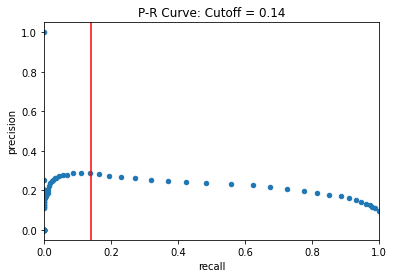

In [0]:
## select the best cutoff

best_cut_2 = prauc.loc[prauc['f1'].idxmax(), 'cutoff'] # Find cutoff w/ max F1
### !!! UNCOMMENT LINES BELOW TO REMEDIATE MINOR FAIRNESS ISSUES !!! ###
# best_cut = 0.3  # min threshold with overall fairness
# best_cut = 0.46 # max accuracy
# best_cut = 0.35 # max MCC
print('%.2f' % best_cut_2)

# Plot P-R AUC w/ best cutoff
title_ = 'P-R Curve: Cutoff = ' + str(best_cut_2)
ax = prauc.plot(x='recall', y='precision', kind='scatter', title=title_, xlim=[0,1])
_ = ax.axvline(best_cut_2, color='r')

In [0]:
y_pred_gs_lgr = np.where(y_pred_prob_lgr>best_cut_2, 1,0)
print(classification_report(test_d[y], y_pred_gs_lgr))

print('Precision is:'+str(round(precision_score(test_d[y], y_pred_gs_lgr),2)))
print('Recall is:'+str(round(recall_score(test_d[y], y_pred_gs_lgr, average='binary'),2)))
print('F1 score is:'+str(round(f1_score(test_d[y], y_pred_gs_lgr, average='binary'),2)))

              precision    recall  f1-score   support

         0.0       0.95      0.77      0.85     35794
         1.0       0.23      0.62      0.33      3868

    accuracy                           0.75     39662
   macro avg       0.59      0.70      0.59     39662
weighted avg       0.88      0.75      0.80     39662

Precision is:0.23
Recall is:0.62
F1 score is:0.33


**Benchmark Disagreement**

One interesting place to start comparing a more complex model to a simpler model is when the simple model is right and the complex model is wrong.

In [0]:
# copy test data
test_yhat2 = test_yhat.copy(deep=True)

# create columns for gbm and glm wrong decisions
test_yhat2.rename(columns={y_hat: 'p_lgb_'+y}, inplace=True)
test_yhat2['p_lgr_'+y] = y_pred_prob_lgr

test_yhat2['lgr_DECISION'] = y_pred_gs_lgr
test_yhat2['lgb_DECISION'] = np.where(test_yhat2['p_lgb_'+y]>best_cut,1,0)

test_yhat2['lgb_WRONG'] = 0
test_yhat2.loc[test_yhat2[y] != test_yhat2['lgb_DECISION'], 'lgb_WRONG'] = 1
test_yhat2['lgr_WRONG'] = 0
test_yhat2.loc[test_yhat2[y] != test_yhat2['lgr_DECISION'], 'lgr_WRONG'] = 1

# create a subset of preds where gbm is wrong, but glm is right
lgb_wrong = test_yhat2.loc[(test_yhat2['lgb_WRONG'] == 1) & (test_yhat2['lgr_WRONG'] == 0)]

lgb_wrong[X + [y, 'p_lgr_'+y, 'p_lgb_'+y]].tail()

,term_360,conforming,debt_to_income_ratio_missing,loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,debt_to_income_ratio,high_priced,p_lgr_high_priced,p_lgb_high_priced
id,,,,,,,,,,,,,
1626611,1.0,1.0,0.0,-0.162598,-2.558594,-4.089844,2.197266,2.300781,-0.029907,0.306152,0.0,0.000373,0.194613
5652078,1.0,1.0,0.0,-0.646484,0.291504,0.244385,-0.215332,-0.628418,-0.037201,-0.059479,1.0,0.149483,0.155245
3888165,1.0,1.0,0.0,-0.162598,0.399902,0.244385,-0.215332,-0.289307,-0.017441,0.489014,0.0,0.125461,0.195859
4026716,1.0,1.0,0.0,-0.294434,0.380371,0.244385,-0.215332,-0.381836,-0.027481,0.214722,0.0,0.126648,0.182040
159199,1.0,1.0,0.0,-0.382568,0.364502,0.244385,-0.215332,-0.443359,-0.029572,0.214722,0.0,0.135596,0.207447


In [0]:
lgb_wrong[[y,'p_lgb_'+y]].sort_values(by='p_lgb_'+y)

,high_priced,p_lgb_high_priced
id,,
6121841,1.0,0.022796
6230019,1.0,0.026412
1703798,1.0,0.027130
5242456,1.0,0.031121
1503223,1.0,0.035253
...,...,...
2698516,0.0,0.409200
1666874,0.0,0.414331
4539870,0.0,0.426182


In [0]:
# plotting ###########
import matplotlib.pyplot as plt                                   # general plotting
from matplotlib.lines import Line2D                               # necessary for custom legends
import seaborn as sns                                             # facet grid for residuals
from mpl_toolkits import mplot3d                                  # 3-D scatterplots
import matplotlib; matplotlib.rcParams.update({'font.size': 10})  # set legible font size

# custom legend
custom = [Line2D([0], [0], color='royalblue', lw=2),
          Line2D([0], [0], color='deeppink', lw=2),
          Line2D([0], [0], marker='o', color='w',
          markerfacecolor='orange', markersize=3)]

# init plot
fig, ax = plt.subplots(figsize=(7, 5)) 

# plot sorted actuals
# double index reset orders index by sort variable and
# brings index into frame for plotting
_ = lgb_wrong[[y,'p_lgb_'+y]].\
            sort_values(by='p_lgb_'+y).\
            reset_index(drop=True).\
            reset_index().\
            plot(kind='scatter', x='index', y=y, color='orange', s=3, ax=ax, 
                 legend=False)

# plot sorted lgb and glm preds 
_ = lgb_wrong[['p_lgr_'+y, 'p_lgb_'+y]].\
            sort_values(by='p_lgb_'+y).\
            reset_index(drop=True).\
            plot(ax=ax, legend=False, 
                 title='Ranked Predictions for Correct lgr and Incorrect lgb')

# annotate plot
_ = ax.legend(custom, ['p_lgr_'+y, 'p_lgb_'+y, 
                       y])
_ = ax.set_xlabel('Ranked Row Index')

This is a chart of everything the lgb model got wrong. For a range of probabilities between ~0.1 and ~0.9 there exists a group of customers where a GLM model gives more correct predictions than the more complex GBM model. In the plot above, the yellow points represent the known target labels, the pink line is the sorted GBM model predictions, and the blue line is the GLM predictions for the same customers and target labels. For this group of people the GLM is obviously able to better represent some attribute of the customer's demographics or behaviors. Can the differences between this group of people and the rest of the customers be identified and leveraged to make better predictions?

Descriptive statistics for rows where GLM benchmark model is right, but GBM is wrong


In [0]:
lgb_wrong.describe() - test_yhat2.describe()

,high_priced,term_360,conforming,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,above62,below62,debt_to_income_ratio_missing,loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,debt_to_income_ratio,p_lgb_high_priced,p_lgr_high_priced,lgr_DECISION,lgb_DECISION,lgb_WRONG,lgr_WRONG
count,-38635.000000,-38635.000000,-38635.000000,-33111.000000,-33111.000000,-33111.000000,-33111.000000,-33111.000000,-33140.000000,-33140.000000,-20871.000000,-20871.000000,-19606.000000,-19606.000000,-38635.000000,-38635.000000,-38635.000000,-38635.000000,-38635.000000,-38635.000000,-38635.000000,-38635.000000,-38635.000000,-3.863500e+04,-38635.000000,-38635.000000,-38635.000000,-38635.000000
mean,0.192749,0.013672,0.024902,0.036133,-0.034637,-0.001953,0.002476,-0.001666,0.054443,-0.054688,0.025879,-0.025879,0.011353,-0.011230,0.001191,-0.218899,0.224854,-0.353180,0.117863,-0.238029,-0.028183,0.142593,0.088327,3.222946e-02,0.020411,0.481858,0.792043,-0.245852
std,0.157471,-0.035522,-0.046143,0.050537,-0.061768,0.002441,0.016663,-0.019196,0.054199,0.054443,-0.006348,-0.006348,0.007812,0.007568,0.016602,-0.081543,-0.111816,0.487305,-0.133789,-0.081543,-1.209595,-0.034180,-0.049639,-3.129270e-02,0.010222,0.034527,-0.405851,-0.430597
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.087891,0.425781,0.000000,0.000000,0.000000,0.000000,0.000000,0.022592,1.013406e-08,0.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.087891,0.477905,0.000000,0.000000,-0.061523,-0.000366,0.274170,0.154912,8.970775e-02,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.043945,0.212891,0.000000,0.000000,-0.123535,-0.003464,0.182800,0.123047,5.244928e-02,0.000000,1.000000,1.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.351746,0.128662,0.000000,0.000000,-0.400757,-0.010223,0.000000,0.036020,-1.859806e-03,0.000000,1.000000,1.000000,0.000000
max,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9.757812,-36.721680,0.000000,-9.656250,-16.625000,-136.612793,0.000000,-0.229551,-4.211064e-01,0.000000,0.000000,0.000000,-1.000000


If this group of people can be isolated, either by descriptive statistics, or by more sophisticated means, the training process could be adapted to fix these errors or another model could be used at scoring time to create more accurate predictions. Even if a group cannot be isolated, the two different model predictions could potentially be blended in this range of predicted probabilities.

#### **Adverserial Examples**

The search for adversarial examples takes a prototype row, perturbs the values of certain variables in the row, and records the new prediction and residual for each new perturbed row.

In [0]:
#### This has to be completely revamped
def find_adversaries(xs, frame, model, row_id, oor_proportion=0.1, 
                     resolution=10, verbose=False):  
    
    """ A brute force function to find adversaries. Dynamically generates nested loops
        to populate adversary_frame with perturbed values and their predictions
        and logloss residuals.
        
        ASSUMES global vars y, yhat, and resid have been defined previously.
        
    Args:    
        xs: List of variables over which to find adversaries.
        frame: Pandas DataFrame for which to calculate bounds for adversary search.
               row_id is assumed to be in frame.
        model: Model to use in adversary search.
        row_id: Prototype row on which the search is based.
        oor_proportion: The proportion by which the search can exceed minimum and 
                        maximum values in frame. Must be between 0-1, default 0.1.
        resolution: The number of points across the domain of xs for which 
                    to search for adversaries, default 10 due to deep nesting.
        verbose: Boolean, whether to print generated code statements.
                
    Returns: 
        Frame containing all tested values and their associated predictions 
        and logloss residuals. 
    
    """
    
    # init dicts to hold bin values
    bins_dict = {}
    
    # find boundaries, bins and record 
    for j in xs:
        
        min_ = frame[j].min()
        max_ = frame[j].max()
        min_ = min_ - np.abs(oor_proportion*min_)
        max_ = max_ + np.abs(oor_proportion*max_)
        by = (max_ - min_)/resolution
        # modify max and by 
        # to preserve resolution and actually search up to max
        bins_dict[j] = np.arange(min_, (max_ + by), (by + np.round((1. / resolution) * by, 3)))
        bins_dict[j] = np.round_(bins_dict[j], 6)  # reasonable precision
    
    # initialize prototype row
    # deep copy to prevent corruption of original data
    row = frame[frame.index == row_id].copy(deep=True)
    
    # generate nested loops dynamically ############################################
    # to search all vals in all search cols
    
    # init true tab
    # define code variable and init returned Pandas DataFrame, adversary_frame
    tab = '    '
    code = 'global adversary_frame\n'
    code += 'adversary_frame = pd.DataFrame(columns=xs)\n'

    # generate for loop statements for search
    for i, j in enumerate(xs):
        code += i*tab + 'for ' + string.ascii_lowercase[i] + ' in ' +\
            str(list(bins_dict[j])) + ':\n'
            
    # generate value assignment statements to perturb search vars
    for k, j in enumerate(xs):
        code += (i + 1)*tab + 'row["' + j + '"] = ' + string.ascii_lowercase[k] +\
            '\n'
    
    # generate progress reporting statements  
    # generate statements for appending test values, preds, and resids to adversary_frame
    # uses only absolute residuals to avoid averaging problems between 0/1 target classes
    code += (i + 1)*tab + 'if (adversary_frame.shape[0] + 1) % 1000 == 0:\n'
    code += (i + 2)*tab +\
        'print("Built %i/%i rows ..." % (adversary_frame.shape[0] + 1, (resolution)**(i+1)))\n'
    code += (i + 1)*tab +\
        'adversary_frame = adversary_frame.append(row, sort=False)\n' 
    code += 'print("Scoring ...")\n'
    code += 'adversary_frame[yhat] = model.predict(adversary_frame)\n'
    code += 'adversary_frame[resid] = np.abs(adversary_frame[y]*np.log(adversary_frame[yhat]) - (1 - adversary_frame[y])*np.log(1 - adversary_frame[yhat]))\n'
    code += 'print("Done.")'
    
    if verbose:
        print('Executing:')
        print(code)
        print('--------------------------------------------------------------------------------')
    
    # execute generated code
    print(code)
    exec(code)
    
    return adversary_frame

The first thing we want to do is identify the most wildley swinging percentile in the partial dependence step. The best way to do this is to take the min-max range of the top X features and multiply it with the shapley values for all percentiles and select the top percentile to be used in the adverserial example.

In [0]:
# merge GBM predictions and residuals onto test data
y_hat = y + "_pred"
resid = y + "_resid" # residuals for use in section 5

yhat_test = test.copy()
yhat_test[y_hat] = model.predict(yhat_test[X])

yhat_test[resid] = -yhat_test[y]*np.log(yhat_test[y_hat]) -\
                             (1 - yhat_test[y])*np.log(1 - yhat_test[y_hat]) # logloss

# find percentiles of predictions
yhat_percentile_dict = get_percentile_dict(y_hat, yhat_test)


# # retreive bins from partial dependence calculation
# bins_PAY_0 = list(par_dep_PAY_0['PAY_0']) 
# bins_AGE = list(par_dep_AGE['AGE']) 

#test_a = test.copy()
resolution = 20

def binned(frame, resolution):
  min_ = frame[xs].min()
  max_ = frame[xs].max()
  by = (max_ - min_)/resolution
  # modify max and by 
  # to preserve resolution and actually search up to max
  bins = np.arange(min_, (max_ + by), (by + np.round((1. / resolution) * by, 3)))
  return bins


par_dep_feat_dict = {}
top_feats = shap_abs_mean.head(5).index.to_list()
for feat in top_feats:
  ## Binned dataframe with standard deviation clipping.
  test_bin = test[X].copy()
  test_bin = test_bin[(test_bin[feat]>-5)&(test_bin[feat]<5)]

  par_dep_feat_dict[feat] = par_dep(feat, test.drop([y],axis=1), model) 
  for i in sorted(yhat_percentile_dict.keys()):
      col_name = 'Percentile_' + str(i)
      par_dep_feat_dict[feat][col_name] = par_dep(feat, test[test.index == int(yhat_percentile_dict[i])][X],  
                                      model, bins= binned(test_bin,resolution),resolution=resolution)['partial_dependence']
    
v_df_list = [] 
for feat in top_feats:
  valdf = par_dep_feat_dict[feat]
  v_df = (valdf.max() - valdf.min()).to_frame().iloc[2:]
  v_df.columns = [feat]
  v_df_list.append(v_df)
v_df_final = pd.concat(v_df_list, axis=1)

v_df_final=(v_df_final-v_df_final.min())/(v_df_final.max()-v_df_final.min())

for col, val in zip(shap_abs_mean.head().index,shap_abs_mean.head().values):
  v_df_final[col] = v_df_final[col]*val

# Normalised Range * Shapley Values
v_df_final.sum(axis=1).sort_values(ascending=False)

Percentile_99    1.979307
Percentile_90    1.472103
Percentile_80    1.384893
Percentile_70    0.988881
Percentile_30    0.800193
Percentile_60    0.765955
Percentile_50    0.705750
Percentile_40    0.514572
Percentile_20    0.426131
Percentile_10    0.241585
Percentile_0     0.000000
dtype: float64

In [0]:
percentile = int(v_df_final.sum(axis=1).sort_values(ascending=False).index[0].split("_")[1]);percentile

99

**Adverserial Simulations**

In [0]:
import string  

resolution= 100000

single = test.loc[yhat_percentile_dict[percentile],:].to_frame().T
sample_frame = single.iloc[np.arange(len(single) * resolution) // resolution]

# init dicts to hold bin values
y_hat = y + '_pred'
resid = y +'_resid' # residuals for use in section 5
search_cols =  top_feats[:2]; print(search_cols)

oor_proportion = 0.1

bins_dict = {}

# find boundaries, bins and record 
# problem with this adverserial search is
for j in search_cols:

    min_ = test_a[j].min()
    max_ = test_a[j].max()
    min_ = min_ - np.abs(oor_proportion*min_)
    max_ = max_ + np.abs(oor_proportion*max_)
    by = (max_ - min_)/resolution
    # modify max and by 
    # to preserve resolution and actually search up to max
    val = np.arange(min_, (max_ + by), (by + np.round((1. / resolution) * by, 3)))[:resolution]
    
    val = np.round_(val, 6)  # reasonable precision
    np.random.shuffle(val)   # added a random shuffle
    sample_frame[j] = val

adversary_frame = sample_frame.copy()
adversary_frame[y_hat] = model.predict(sample_frame[X])
adversary_frame[resid] = np.abs(adversary_frame[y]*np.log(adversary_frame[y_hat]) - (1 - adversary_frame[y])*np.log(1 - adversary_frame[y_hat]))

yhat_adversaries = adversary_frame.copy().reset_index(drop=True)

['loan_to_value_ratio', 'property_value']


In [0]:
## Might have to use testa for smaller variations. 
yhat_adversaries.sort_values(by=y_hat).head(n=3)

,high_priced,term_360,conforming,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,above62,below62,debt_to_income_ratio_missing,loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,debt_to_income_ratio,high_priced_pred,high_priced_resid
49999,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,0.0,1.0,0.0,-0.470459,-0.465430,-4.089844,2.197266,23.008358,-0.028183,1.585938,0.190047,0.210779
70034,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,0.0,1.0,0.0,-0.470459,-1.022988,-4.089844,2.197266,21.322102,-0.028183,1.585938,0.190047,0.210779
22745,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,0.0,1.0,0.0,-0.470459,-3.006170,-4.089844,2.197266,21.723413,-0.028183,1.585938,0.190047,0.210779


Below shows that a lower loan to value ratio and higher property value led to a lower priced prediction. However the high_priced_pred still does not surpass the 0.17 cutoff that would make it a low priced prediction. This is a good robust outcome, you can try as you want to fool the model by adjusting these two features but you won' be able to change the result.

In [0]:
yhat_adversaries.sort_values(by=y_hat).iloc[0] - single

,above62,amind,asian,below62,black,conforming,debt_to_income_ratio,debt_to_income_ratio_missing,female,high_priced,high_priced_pred,high_priced_resid,hipac,hispanic,income,intro_rate_period,loan_amount,loan_to_value_ratio,male,no_intro_rate_period,non_hispanic,property_value,term_360,white
1600892,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,-1.017578,NaN,0.0,0.0,23.546875,0.0,0.0


In [0]:
### Lets add another feature to see if we can change some 1s to 0s.

bins_dict = {}
search_cols =  top_feats[:3]; print(search_cols)

for j in search_cols:

    min_ = test_a[j].min()
    max_ = test_a[j].max()
    min_ = min_ - np.abs(oor_proportion*min_)
    max_ = max_ + np.abs(oor_proportion*max_)
    by = (max_ - min_)/resolution
    # modify max and by 
    # to preserve resolution and actually search up to max
    val = np.arange(min_, (max_ + by), (by + np.round((1. / resolution) * by, 3)))[:resolution]
    
    val = np.round_(val, 6)  # reasonable precision
    np.random.shuffle(val)   # added a random shuffle
    sample_frame[j] = val

adversary_frame = sample_frame.copy()
adversary_frame[y_hat] = model.predict(sample_frame[X])
adversary_frame[resid] = np.abs(adversary_frame[y]*np.log(adversary_frame[y_hat]) - (1 - adversary_frame[y])*np.log(1 - adversary_frame[y_hat]))

yhat_adversaries = adversary_frame.copy().reset_index(drop=True)

['loan_to_value_ratio', 'property_value', 'debt_to_income_ratio']


In [0]:
yhat_adversaries[y_hat+"_cut"] = np.where(yhat_adversaries[y_hat]>best_cut,1,0)

**Proximate Examples**

There is mostly a fair split, but there is a few corner cases that look like they could be turned into high price prediction.

In [0]:
small_cat = yhat_adversaries[y_hat+"_cut"].value_counts().sort_values()
values_small = small_cat.values[0]
small_cat = small_cat.index[0]
new_balanced = pd.concat([yhat_adversaries[yhat_adversaries[y_hat+"_cut"]==small_cat],yhat_adversaries.sample(values_small) ],axis=0).sample(500)

In [0]:
import plotly.express as px
df = px.data.iris()
fig = px.scatter_3d(new_balanced, x=search_cols[0], y=search_cols[1], z=search_cols[2],
              color=y_hat+"_cut",hover_data=[new_balanced.index])
fig.show()

In [0]:
import plotly.express as px
df = px.data.iris()
fig = px.scatter_3d(new_balanced, x=search_cols[0], y=search_cols[1], z=search_cols[2],
              color=y_hat,hover_data=[new_balanced.index])
fig.show()

## Step 3 - Fairness

Group fairness, in its broadest sense, partitions a population into groups defined by protected attributes and seeks for some statistical measure to be equal across groups.  Individual fairness, in its broadest sense, seeks for similar individuals to be treated similarly.  

### **Group Level**

**Disparate Error Analysis**

In [0]:
metric_dict = {

#### overall performance
'Prevalence   ': '(tp + fn) / (tp + tn +fp + fn)', # how much default actually happens for this group
#'Adverse Impact': '(tp + fp) / (tp + tn + fp + fn)', # how often the model predicted default for each group   
'Accuracy   ':       '(tp + tn) / (tp + tn + fp + fn)', # how often the model predicts default and non-default correctly for this group

#### predicting default will happen
# (correctly)
'True Positive Rate   ': 'tp / (tp + fn)',  # out of the people in the group *that did* default, how many the model predicted *correctly* would default              
'Precision   ':          'tp / (tp + fp)',  # out of the people in the group the model *predicted* would default, how many the model predicted *correctly* would default

#### predicting default won't happen
# (correctly)
'Specificity   ':              'tn / (tn + fp)', # out of the people in the group *that did not* default, how many the model predicted *correctly* would not default
'Negative Predicted Value   ': 'tn / (tn + fn)', # out of the people in the group the model *predicted* would not default, how many the model predicted *correctly* would not default  

#### analyzing errors - type I
# false accusations 
'False Positive Rate   ':  'fp / (tn + fp)', # out of the people in the group *that did not* default, how many the model predicted *incorrectly* would default
'False Discovery Rate   ': 'fp / (tp + fp)', # out of the people in the group the model *predicted* would default, how many the model predicted *incorrectly* would default

#### analyzing errors - type II
# costly ommisions
'False Negative Rate   ': 'fn / (tp + fn)', # out of the people in the group *that did* default, how many the model predicted *incorrectly* would not default
'False Omissions Rate   ':'fn / (tn + fn)'  # out of the people in the group the model *predicted* would not default, how many the model predicted *incorrectly* would not default
}   

# small utility functions
# all tightly coupled to global names and data structures !!

def cm_exp_parser(expression):
    
    """ Translates abbreviated metric expressions from metric_dict 
        into executable Python statements.
    
    Arg: 
        expression: Error metric expression from metric_dict.
        
    Returns:
        Python statements based on predefined metrics in metric_dict.
        
    """
    
    # tp | fp       cm_dict[level].iat[0, 0] | cm_dict[level].iat[0, 1]
    # -------  ==>  --------------------------------------------
    # fn | tn       cm_dict[level].iat[1, 0] | cm_dict[level].iat[1, 1]

    expression = expression.replace('tp', '(cm_dict[level].iat[0, 0] + eps)')\
                           .replace('fp', '(cm_dict[level].iat[0, 1] + eps)')\
                           .replace('fn', '(cm_dict[level].iat[1, 0] + eps)')\
                           .replace('tn', '(cm_dict[level].iat[1, 1] + eps)')

    return expression

################################################################################

def get_cm_dict(test_yhat, name, cutoff):

    """ Loops through levels of named variable and calculates confusion 
        matrices per level; uses dynamically generated entities to reduce 
        code duplication. 
    
    Args:
        name: Name of variable for which to calculate confusion matrices.
        cutoff: Cutoff threshold for confusion matrices. 
    
    Returns:
        Dictionary of confusion matrices. 
    
    """

    levels = sorted(list(test_yhat[name].unique())) # get levels
    cm_dict = {} # init dict to store confusion matrices per level
    for level in levels: 
    
        # dynamically name confusion matrices by level
        # coerce to proper python names
        cm_name = '_' + str(level).replace('-', 'm') + '_cm' 
    
        # dynamically calculate confusion matrices by level
        coda = cm_name + ''' = get_confusion_matrix(test_yhat,                              
                          y, 
                          y_hat, 
                          by=name, 
                          level=level, 
                          cutoff=cutoff)'''
        exec(coda)
        exec('cm_dict[level] = ' + cm_name) # store in dict
                
    return cm_dict

################################################################################

def get_metrics_frame(test_yhat,cm_dict ,name): 

    """ Loops through levels of named variable and metrics to calculate each 
        error metric per each level of the variable; uses dynamically generated 
        entities to reduce code duplication.
    
    Arg:
        name: Name of variable for which to calculate error metrics.
    
    Return:
        Pandas DataFrame of error metrics.
        
    """
    
    levels = sorted(list(test_yhat[name].unique())) # get levels
    metrics_frame = pd.DataFrame(index=levels) # init Pandas frame for metrics
    eps = 1e-20 # for safe numerical operations

    # nested loop through:
    # - levels
    # - metrics 
    for level in levels:
        for metric in metric_dict.keys():
              
            # parse metric expressions into executable pandas statements
            expression = cm_exp_parser(metric_dict[metric])
        
            # dynamically evaluate metrics to avoid code duplication
            metrics_frame.loc[level, metric] = eval(expression)  

    # display results
    return metrics_frame

In [0]:
def get_confusion_matrix(frame, y, yhat, by=None, level=None, cutoff=0.5):

    """ Creates confusion matrix from pandas dataframe of y and yhat values, 
        can be sliced by a variable and level.
 
    Args:
        frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        y: Name of actual value column.
        yhat: Name of predicted value column.
        by: By variable to slice frame before creating confusion matrix, 
            default None.
        level: Value of by variable to slice frame before creating confusion 
               matrix, default None.
        cutoff: Cutoff threshold for confusion matrix, default 0.5. 

    Returns:
        Confusion matrix as pandas dataframe. 
    """
    
    # determine levels of target (y) variable
    # sort for consistency
    level_list = list(frame[y].unique())
    level_list.sort(reverse=True)

    # init confusion matrix
    cm_frame = pd.DataFrame(columns=['actual: ' +  str(i) for i in level_list], 
                            index=['predicted: ' + str(i) for i in level_list])
    
    # don't destroy original data
    frame_ = frame.copy(deep=True)
    
    # convert numeric predictions to binary decisions using cutoff
    dname = 'd_' + str(y)
    frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)
    
    # slice frame
    if (by is not None) & (level is not None):
        frame_ = frame_[frame[by] == level]
    
    # calculate size of each confusion matrix value
    for i, lev_i in enumerate(level_list):
        for j, lev_j in enumerate(level_list):
            cm_frame.iat[j, i] = frame_[(frame_[y] == lev_i) & 
                                        (frame_[dname] == lev_j)].shape[0]
            # i,j vs. j,i - nasty little bug updated 8/30/19
    
    return cm_frame


*Majoritarian Fairness*

Train the model on all feature, including sensitive feature, then choose the model demographic intersection as the only prediction class, thus making the model superficially colour blind, i.e. change the test set to all have the same demographical characteristics.

In [0]:
## Majoriterian Fairness

X_sens = X + sensitive
#train = train.fillna(train.mean())
#train_sens = train.copy()
train[sensitive]=train[sensitive].fillna(train.mode().iloc[0])
sens_dict = {}
for sen in sensitive:
  sens_dict[sen] = train[sensitive][sen].value_counts().sort_values(ascending=False).index.to_list()[0]

for sen in sensitive:
  test[sen] = sens_dict[sen]

In [168]:
#sens_params = new_params
sens_params = best_params
mono_str_sens, _ = monotone(train, X_sens, y, constrained); print(mono_str_sens)
sens_params["monotone_constraints"] = mono_str_sens

d_train = lgb.Dataset(train[X_sens], label=train[y])
d_test = lgb.Dataset(test[X_sens], label=test[y])
model_sens = lgb.train(sens_params, d_train, verbose_eval=1000)
y_pred_test = model_sens.predict(test[X_sens])
perf = roc_auc_score(test[y], y_pred_test)
print('ROC AUC {}'.format(perf))

1,0,0,-1,1,0,0,-1,0,1,0,0,0,0,0,0,0,0,0,0,0
ROC AUC 0.8119781698954243


In [0]:
y_hat = y + "_pred"
test_yhat_sens = test.copy()
test_yhat_sens[sensitive] = test_yhat_sens[sensitive].astype(int)
test_yhat_sens[y_hat] = y_pred_test

## Bring original demographics back after prediction
test_org[sensitive]=test_org[sensitive].fillna(test_org.mode().iloc[0])
for sens in sensitive:
  test_yhat_sens[sens] = test_org[sens].astype(int)

In [0]:
test_yhat[sensitive]=test_yhat[sensitive].fillna(test_yhat.mode().iloc[0])
test_yhat[sensitive] = test_yhat[sensitive].astype(int)

In [0]:
import seaborn as sns 

def error_metrics(df, characteristic, cut_off):
  cm_dict = get_cm_dict(df, characteristic, cut_off) # get dict of confusion matrices

  # print formatted error metrics frame: precision, title, colors
  metrics = get_metrics_frame(df, cm_dict, characteristic)

  levels = list(df[characteristic].unique())
  metrics[characteristic] = levels
  metrics.set_index(characteristic, inplace=True)
  metrics = metrics.sort_index(ascending=False)
  return metrics

def metric_figure(metrics, characteristic):
  return metrics.round(3).\
      style.set_caption('Error Metrics for ' + characteristic).\
      background_gradient(cmap=sns.diverging_palette(-20, 260, n=7, as_cmap=True), 
                          axis=1)
      
def display_frame(metrics):
  ref_level = 1 # white

  disp_frame = pd.DataFrame(index=metrics.index)

  # compare all metrics to reference level
  disp_frame = metrics/metrics.loc[ref_level, :]

  # change column names
  disp_frame.columns=[col + ' Disparity' for col in metrics.columns]

  return disp_frame
   
def relative_figure(disp_frame):

  parity_threshold_low = 0.8    # user-defined low threshold value
  parity_threshold_hi = 1.25    # user-defined high threshold value

  # small utility function to format pandas table output
  def disparate_red(val):
      
      color = 'blue' if (parity_threshold_low < val < parity_threshold_hi) else 'red'
      return 'color: %s' % color 

  # display results
  return disp_frame.style.applymap(disparate_red)

def parity_indicators(metrics, disp_frame):

  # parity checks
  # low_threshold (0.8) < *_metric/white_metric < (high_threshold) 1.25 => parity, else disparity 

  parity_threshold_low = 0.8    # user-defined low threshold value
  parity_threshold_hi = 1.25    # user-defined high threshold value

  levels = metrics.index.to_list()
  # init frame for parity
  par_frame = pd.DataFrame(index=levels, 
                          columns=[col[:-3] + ' Parity' for col in metrics.columns])
  # nested loop through: 
  # - races
  # - disparity metrics
  for i, _ in enumerate(levels):
      for j, _ in enumerate(par_frame.columns):
          par_frame.iat[i, j] = (parity_threshold_low < disp_frame.iat[i, j] < parity_threshold_hi)

  # add overall parity checks
  # Type I Parity: Fairness in both FDR Parity and FPR Parity
  # Type II Parity: Fairness in both FOR Parity and FNR Parity
  # Equalized Odds: Fairness in both FPR Parity and TPR Parity
  # Supervised Fairness: Fairness in both Type I and Type II Parity
  # Overall Fairness: Fairness across all parities for all metrics
  par_frame['Type I Parity'] = (par_frame['False Discovery Rate Parity']) & (par_frame['False Positive Rate Parity'])
  par_frame['Type II Parity'] = (par_frame['False Omissions Rate Parity']) & (par_frame['False Negative Rate Parity'])
  par_frame['Equalized Odds'] = (par_frame['False Positive Rate Parity']) & (par_frame['True Positive Rate Parity'])
  par_frame['Supervised Fairness'] = (par_frame['Type I Parity']) & (par_frame['Type II Parity'])
  par_frame['Overall Fairness'] = par_frame.all(axis='columns')
  par_frame.loc['all', :] = par_frame.all(axis='index')
      
  # small utility function to format pandas table output    
  def color_false_red(val):

      color = 'red' if not val else 'blue'
      return 'color: %s' % color 
      
  return par_frame.style.applymap(color_false_red)

In [0]:
metrics = mt_white

In [0]:
levels = metrics.index.to_list()
# init frame for parity
par_frame = pd.DataFrame(index=levels, 
                        columns=[col[:-3] + ' Parity' for col in metrics.columns])

In [0]:
par_frame['False Discovery Rate Parity']

1    NaN
0    NaN
Name: False Discovery Rate Parity, dtype: object

In [0]:
mt_white = error_metrics(test_yhat_sens,'white',best_cut)
metric_figure(mt_white, 'white')

,Prevalence,Accuracy,True Positive Rate,Precision,Specificity,Negative Predicted Value,False Positive Rate,False Discovery Rate,False Negative Rate,False Omissions Rate
white,,,,,,,,,,
1,0.092,0.84,0.428,0.268,0.882,0.938,0.118,0.732,0.572,0.062
0,0.132,0.807,0.398,0.317,0.869,0.905,0.131,0.683,0.602,0.095


In [0]:
disp_white = display_frame(mt_white)
relative_figure(disp_white)

,Prevalence Disparity,Accuracy Disparity,True Positive Rate Disparity,Precision Disparity,Specificity Disparity,Negative Predicted Value Disparity,False Positive Rate Disparity,False Discovery Rate Disparity,False Negative Rate Disparity,False Omissions Rate Disparity
white,,,,,,,,,,
1,1,1,1,1,1,1,1,1,1,1
0,1.43542,0.960809,0.929763,1.17954,0.985853,0.964221,1.10562,0.934136,1.05266,1.54592


**Prevalance:** there are about 40% more defaults for non-white groups in the dataset *--Bad Sign For Minority--*. **Accuracy:** the accuracy in prediction is 4% lower for non-white groups. **TPR:** the model better predicted those who would default for white rather than non-white groups (7pp difference) *--Good Sign For Minority--*. **Precision:** when the model predicted that someone would default, it was more precise in predicting that for non-white groups. *--Good Sign For Minority--*. **Specificicty:** of the people that did not default, the model correctly predicted those non-defaults in a similar ratio between groups. **NPV:** for model predicted non-defaults, there was an equal ratio of correctly predicted non-defaults between white and non-white groups. **FPR (Important):** out of the people that did not default, the model incorrectly predicted that more non-whites would proportionately default (10pp). *--Bad Sign For Minority--* **FDR (Important):** The model incorrectly predicted that more whites would default that did not default (7pp). *--Good Sign For Minority--* **FNR (Important):** For the amount of people that would default, the model predicted more incorrectly that non-whites would not default. *--Good Sign For Minority--* **FOR (Important):** 50% more of the time the model incorrectly predicted that non-whites would not default, but they did default. *--Good Sign For Minority--*  out of the people in the group the model *predicted* would not default, how many the model predicted *incorrectly* would not default

In [0]:
mt_male = error_metrics(test_yhat,'male',best_cut)
metric_figure(mt_male, 'male')

,Prevalence,Accuracy,True Positive Rate,Precision,Specificity,Negative Predicted Value,False Positive Rate,False Discovery Rate,False Negative Rate,False Omissions Rate
male,,,,,,,,,,
1,0.122,0.747,0.683,0.281,0.756,0.945,0.244,0.719,0.317,0.055
0,0.091,0.804,0.574,0.249,0.827,0.951,0.173,0.751,0.426,0.049


In [0]:
disp_male = display_frame(mt_male)
relative_figure(disp_male)

,Prevalence Disparity,Accuracy Disparity,True Positive Rate Disparity,Precision Disparity,Specificity Disparity,Negative Predicted Value Disparity,False Positive Rate Disparity,False Discovery Rate Disparity,False Negative Rate Disparity,False Omissions Rate Disparity
male,,,,,,,,,,
1,1,1,1,1,1,1,1,1,1,1
0,0.743013,1.07558,0.840298,0.886026,1.09323,1.00656,0.710599,1.04456,1.3442,0.887762


FPR (Important): out of the people that did not default, the model incorrectly predicted that more males would proportionately default (30pp). --Good Sign For Minority-- FDR (Important): The model incorrectly predicted that more females would default that did not default (4pp). --Bad Sign For Minority-- FNR (Important): For the amount of people that would default, the model predicted more incorrectly that females would not default. --Good Sign For Minority-- FOR (Important): 12% more of the time the model incorrectly predicted that men would not default, but they did default. --Bad Sign For Minority-- out of the people in the group the model predicted would not default, how many the model predicted incorrectly would not default.

In [0]:
# ax = disp_frame['False Omissions Rate Disparity'].plot(kind='bar', color='b', title='False Omissions Rate Disparity')
# _ = ax.axhline(parity_threshold_low, color='r', linestyle='--')
# _ = ax.axhline(parity_threshold_hi, color='r', linestyle='--')

**Parity Indicators**

A binary indication of parity for metrics is reported by simply checking whether disparity values are within the user-defined thresholds. Further parity indicators are defined as combinations of other disparity values:

    Type I Parity: Both FDR Parity and FPR Parity
    Type II Parity: Both FOR Parity and FNR Parity
    Equalized Odds: Both FPR Parity and TPR Parity
    Supervised Fairness: Both Type I and Type II Parity
    Overall Fairness: Fairness across all metrics


In [0]:
parity_indicators(mt_white, disp_white)

,Prevalence Parity,Accuracy Parity,True Positive Rate Parity,Precision Parity,Specificity Parity,Negative Predicted Value Parity,False Positive Rate Parity,False Discovery Rate Parity,False Negative Rate Parity,False Omissions Rate Parity,Type I Parity,Type II Parity,Equalized Odds,Supervised Fairness,Overall Fairness
1,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
0,False,True,True,True,True,True,True,True,True,False,True,False,True,False,False
all,False,True,True,True,True,True,True,True,True,False,True,False,True,False,False


The model is suffering from disparity problems against the privilidged group.

**Fair Lending Measures**

*Simple function to calculate adverse impact ratio (AIR)*

AIR is perhaps the most well-known discrimination measure. It was first delineated by the U.S. Equal Employment Opportunity Commission (EEOC) and AIR is associated with the convenient 4/5ths, or 0.8, cutoff threshold. AIR values below 0.8 can be considered evidence of illegal discrimination in many lending or employment scenarios in the U.S.


In [0]:
dict_level = {0:"Non-white", 1:"White"}
def air(reference, protected):

    """ Calculates the adverse impact ratio as a quotient between protected and 
        reference group acceptance rates: protected_prop/reference_prop. 
        Prints intermediate values. Tightly coupled to cm_dict. 
    
    Args:
        reference: name of reference group in cm_dict as a string.
        protected: name of protected group in cm_dict as a string.

    Returns:
        AIR as a formatted string. 
        
    """

    # reference group summary
    reference_accepted = float(cm_dict[reference].iat[1,0] + cm_dict[reference].iat[1,1]) # predicted 0's
    reference_total = float(cm_dict[reference].sum().sum())
    reference_prop = reference_accepted/reference_total
    print(dict_level[reference] + ' proportion accepted: %.3f' % reference_prop)
    
    # protected group summary
    protected_accepted = float(cm_dict[protected].iat[1,0] + cm_dict[protected].iat[1,1]) # predicted 0's
    protected_total = float(cm_dict[protected].sum().sum())
    protected_prop = protected_accepted/protected_total
    print(dict_level[protected] + ' proportion accepted: %.3f' % protected_prop)

    # return adverse impact ratio
    return 'Adverse impact ratio: %.3f' % (protected_prop/reference_prop)


print(air(1, 0))

1 proportion accepted: 0.778
Non-white proportion accepted: 0.738
Adverse impact ratio: 0.948


*Simple function to calculate marginal effect*

Marginal effect describes the difference between the percent of the reference group awarded a loan and the percent of the protected group awarded a loan under a model.


In [0]:
def marginal_effect(reference, protected):

    """ Calculates the marginal effect as a percentage difference between a reference and 
        a protected group: reference_percent - protected_percent. Prints intermediate values. 
        Tightly coupled to cm_dict. 
    
    Args:
        reference: name of reference group in cm_dict as a string.
        protected: name of protected group in cm_dict as a string.

    Returns:
        Marginal effect as a formatted string. 
        
    """
    
    # reference group summary
    reference_accepted = float(cm_dict[reference].iat[1,0] + cm_dict[reference].iat[1,1]) # predicted 0's
    reference_total = float(cm_dict[reference].sum().sum())
    reference_percent = 100*(reference_accepted/reference_total)
    print(dict_level[reference]  + ' accepted: %.2f%%' % reference_percent)
    
    # protected group summary
    protected_accepted = float(cm_dict[protected].iat[1,0] + cm_dict[protected].iat[1,1]) # predicted 0's
    protected_total = float(cm_dict[protected].sum().sum())
    protected_percent = 100*(protected_accepted/protected_total)
    print(dict_level[protected] + ' accepted: %.2f%%' % protected_percent)
    
    # return marginal effect
    return 'Marginal effect: %.2f%%' % (reference_percent - protected_percent)

print(marginal_effect(1, 0))

White accepted: 77.77%
Non-white accepted: 73.76%
Marginal effect: 4.01%


About 78% of hites are awarded a loan by the model. About 74% of non-whites are awarded a loan. This results in a marginal effect of +4%.

*Standardized mean difference*

The standardized mean difference (SMD), i.e. Cohen's D, is the mean value of the prediction for the protected group minus the mean prediction for the reference group, all divided by the standard deviation of the prediction.


In [0]:
def smd(frame, yhat, j, reference, protected):
    
    """ Calculates standardized mean difference between a protected and reference group:
    (mean(yhat | j=protected) - mean(yhat | j=reference))/sigma(yhat). 
    Prints intermediate values. 
    
    Args:
        frame: Pandas dataframe containing j and predicted (y_hat) values.
        yhat: Name of predicted value column.
        j: name of demographic column containing reference and protected group labels. 
        reference: name of reference group in j.
        protected: name of protected group in j. 

    Returns:
       Standardized mean difference as a formatted string.
       
    """
    
    # yhat mean for j=reference
    reference_yhat_mean = frame[frame[j] == reference][y_hat].mean()
    print(dict_level[reference] + ' mean yhat: %.2f' % reference_yhat_mean)
    
    #yhat mean for j=protected 
    protected_yhat_mean = frame[frame[j] == protected][y_hat].mean()
    print(dict_level[protected] + ' mean yhat: %.2f' % protected_yhat_mean)
    
    # std for yhat
    sigma = frame[y_hat].std()
    print(y_hat.title() + ' std. dev.:  %.2f' % sigma)
    
    return 'Standardized Mean Difference: %.2f' % ((protected_yhat_mean - reference_yhat_mean)/sigma)
    
print(smd(test_yhat, y_hat, name, 1, 0))

White mean yhat: 0.09
Non-white mean yhat: 0.10
High_Priced_Pred std. dev.:  0.10
Standardized Mean Difference: 0.07


For this model, in the test set, whites receive a lower average probability of an expensive loan than non-whites. This difference is evident even after standardizing with the standard deviation of the predictions.

#### **Model Agnostic Pre-and Post-Processing**


Among pre-processing algorithms, reweighing only changes weights applied to training samples; it does not change any feature or label values. Therefore, it may be a preferred option in case the application does not allow for value changes. Disparate impact remover and optimized pre-processing yield modified datasets in the same space as the input training data, whereas LFR’s pre-processed dataset is in a latent space.  If the application requires transparency on the transformation, then disparate impact remover and optimized pre-processing may be preferred options. Moreover, optimized pre-processing addresses both group fairness and individual fairness.

Among post-processing algorithms, the two equalized odds post-processing algorithms have a randomized component whereas the reject option algorithm is deterministic, and may be preferred for that reason.

The current AIF360 implementations of some algorithms take arguments on which fairness metric to optimize (e.g. optimized pre-processing and reject option) and some do not (e.g. disparate impact remover and equalized odds post-processing), which may imply better and worse performance by some algorithms with respect to some metrics.

In [0]:
!pip install aif360

     |████████████████████████████████| 56.4MB 55kB/s 


In [0]:
# Load all necessary packages
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
from IPython.display import Markdown, display
import matplotlib.pyplot as plt

#Datasets
from aif360.datasets.meps_dataset_panel19_fy2015 import MEPSDataset19

#Fairness Metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

#Bias Mitigation Techniques
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.inprocessing.prejudice_remover import PrejudiceRemover
from aif360.algorithms.preprocessing import DisparateImpactRemover

#sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

import pandas as pd
import sys
import numpy as np
np.random.seed(0)
from aif360.datasets import StructuredDataset as SD
from aif360.datasets import BinaryLabelDataset as BLD
from aif360.metrics import ClassificationMetric as CM
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.datasets import make_classification as mc 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [0]:
#Validate model on given dataset and find threshold for best balanced accuracy
def validate_visualize(dataset, y_pred_proba):
    thresh_arr = np.linspace(0.01, 0.7, 50)

    bal_acc_arr = []
    disp_imp_arr = []
    avg_odds_diff_arr = []
    stat_par_diff = []
    eq_opp_diff = []
    theil_ind = []

    for thresh in tqdm(thresh_arr):
        y_validate_pred = (y_pred_proba[:,1] > thresh).astype(np.double)

        dataset_pred = dataset.copy()
        dataset_pred.labels = y_validate_pred

        classified_metric = ClassificationMetric(dataset, 
                                                 dataset_pred,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
        metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)

        TPR = classified_metric.true_positive_rate()
        TNR = classified_metric.true_negative_rate()
        bal_acc = 0.5*(TPR+TNR)

        acc = accuracy_score(y_true=dataset.labels,
                             y_pred=dataset_pred.labels)
        bal_acc_arr.append(bal_acc)
        avg_odds_diff_arr.append(classified_metric.average_odds_difference())
        disp_imp_arr.append(metric_pred.disparate_impact())
        stat_par_diff.append(classified_metric.statistical_parity_difference())
        eq_opp_diff.append(classified_metric.equal_opportunity_difference())
        theil_ind.append(classified_metric.theil_index())


    thresh_arr_best_ind = np.where(bal_acc_arr == np.max(bal_acc_arr))[0][0]
    thresh_arr_best = np.array(thresh_arr)[thresh_arr_best_ind]

    best_bal_acc = bal_acc_arr[thresh_arr_best_ind]
    disp_imp_at_best_bal_acc = np.abs(1.0-np.array(disp_imp_arr))[thresh_arr_best_ind]

    avg_odds_diff_at_best_bal_acc = avg_odds_diff_arr[thresh_arr_best_ind]

    stat_par_diff_at_best_bal_acc = stat_par_diff[thresh_arr_best_ind]
    eq_opp_diff_at_best_bal_acc = eq_opp_diff[thresh_arr_best_ind]
    theil_ind_at_best_bal_acc = theil_ind[thresh_arr_best_ind]
    
    #Plot balanced accuracy, abs(1-disparate impact)
    %matplotlib inline

    fig, ax1 = plt.subplots(figsize=(8,4))
    ax1.plot(thresh_arr, bal_acc_arr)
    ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)


    ax2 = ax1.twinx()
    ax2.plot(thresh_arr, np.abs(1.0-np.array(disp_imp_arr)), color='r')
    ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')

    ax2.axvline(np.array(thresh_arr)[thresh_arr_best_ind], 
                color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.grid(True)

    fig, ax1 = plt.subplots(figsize=(8,4))
    ax1.plot(thresh_arr, bal_acc_arr)
    ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)


    ax2 = ax1.twinx()
    ax2.plot(thresh_arr, avg_odds_diff_arr, color='r')
    ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')

    ax2.axvline(np.array(thresh_arr)[thresh_arr_best_ind], color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.grid(True)

    print("Threshold corresponding to Best balanced accuracy: %6.4f" % thresh_arr_best)
    print("Best balanced accuracy: %6.4f" % best_bal_acc)
    print("Corresponding abs(1-disparate impact) value: %6.4f" % disp_imp_at_best_bal_acc)
    print("Corresponding average odds difference value: %6.4f" % avg_odds_diff_at_best_bal_acc)
    print("Corresponding statistical parity difference value: %6.4f" % stat_par_diff_at_best_bal_acc)
    print("Corresponding equal opportunity difference value: %6.4f" % eq_opp_diff_at_best_bal_acc)
    print("Corresponding Theil index value: %6.4f" % theil_ind_at_best_bal_acc)
    return thresh_arr_best

#Evaluate performance of a given model with a given threshold on a given dataset

def validate_test(dataset, y_pred_proba, threshold):
    y_pred = (y_pred_proba[:,1] > threshold).astype(np.double)

    dataset_pred = dataset.copy()
    dataset_pred.labels = y_pred

    classified_metric = ClassificationMetric(dataset, 
                                            dataset_pred,
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)
    metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)

    TPR = classified_metric.true_positive_rate()
    TNR = classified_metric.true_negative_rate()
    bal_acc = 0.5*(TPR+TNR)

    acc = accuracy_score(y_true=dataset.labels,
                        y_pred=dataset_pred.labels)

    #get results
    best_bal_acc = bal_acc
    disp_imp_at_best_bal_acc = np.abs(1.0-metric_pred.disparate_impact())
    avg_odds_diff_at_best_bal_acc = classified_metric.average_odds_difference()
    stat_par_diff_at_best_bal_acc = classified_metric.statistical_parity_difference()
    eq_opp_diff_at_best_bal_acc = classified_metric.equal_opportunity_difference()
    theil_ind_at_best_bal_acc = classified_metric.theil_index()
    
    print("Threshold corresponding to Best balanced accuracy: %6.4f" % threshold)
    print("Best balanced accuracy: %6.4f" % best_bal_acc)
    print("Corresponding abs(1-disparate impact) value: %6.4f" % disp_imp_at_best_bal_acc)
    print("Corresponding average odds difference value: %6.4f" % avg_odds_diff_at_best_bal_acc)
    print("Corresponding statistical parity difference value: %6.4f" % stat_par_diff_at_best_bal_acc)
    print("Corresponding equal opportunity difference value: %6.4f" % eq_opp_diff_at_best_bal_acc)
    print("Corresponding Theil index value: %6.4f" % theil_ind_at_best_bal_acc)
    
    return {"best_bal_acc": best_bal_acc,
            "disp_imp": disp_imp_at_best_bal_acc,
            "avg_odds_diff": avg_odds_diff_at_best_bal_acc,
            "stat_par_diff": stat_par_diff_at_best_bal_acc,
            "eq_opp_diff": eq_opp_diff_at_best_bal_acc,
            "theil_ind": theil_ind_at_best_bal_acc}

In [0]:
## NB use this to switch majoritarianism on and of
majority = True #False
if majority==True:
  # Majoritarian
  test_use = test.copy()
  test_use["white_org"] = test_org["white"]
  X_sens_w = X_sens.copy()
  X_use = X_sens_w
  cut_feat = 1 
  model = model_sens
  category = "white_org"
else:
  # Normal
  test_use = test_org.copy()
  X_use = X
  cut_feat = 1
  category = "white"

priv = 1
unpriv = 0

df_all = pd.concat([train, test_use],axis=0)
df_all = df_all.fillna(df_all.median())

# 0 label means no defualt, 1 means default
dataset = BLD(favorable_label=0, unfavorable_label=1,df=df_all[X_use +[y,category]],
              label_names=[y], protected_attribute_names=[category], 
              privileged_protected_attributes=[unpriv])
prop = len(train)/len(df_all)
orig_train, orig_validate, orig_test = dataset.split([0.5,prop], shuffle=False)

In [0]:
# print out some labels, names, etc.
print("#### Training Dataset shape")
print(orig_train.features.shape)
print("#### Validation Dataset shape")
print(orig_validate.features.shape)
print("#### Test Dataset shape")
print(orig_test.features.shape)
print("#### Favorable and unfavorable labels")
print(orig_train.favorable_label, orig_train.unfavorable_label)
print("#### Protected attribute names")
print(orig_train.protected_attribute_names)
print("#### Privileged and unprivileged protected attribute values")
print(orig_train.privileged_protected_attributes, 
      orig_train.unprivileged_protected_attributes)

#### Training Dataset shape
(100000, 22)
#### Validation Dataset shape
(60338, 22)
#### Test Dataset shape
(39662, 22)
#### Favorable and unfavorable labels
0.0 1.0
#### Protected attribute names
['white_org']
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]


**Original Model**

The mean effect on the training dataset shows that non-white's are trated favourably.

In [0]:
# Metric for the original dataset
sens_attr = category
sens_idx = unpriv
privileged_groups =  [{sens_attr:priv}]
unprivileged_groups = [{sens_attr:unpriv}]
metric_orig_train = BinaryLabelDatasetMetric(orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("#### Original training dataset")
print("Difference in mean favourable outcomes between unprivileged and privileged groups = %f" % \
                                                  metric_orig_train.mean_difference())
print("Disparate impact (ratio of unprivileged favorable mean to privileged favorable mean) = %f" % \
                                                  metric_orig_train.disparate_impact())

#### Original training dataset
Difference in mean favourable outcomes between unprivileged and privileged groups = nan
Disparate impact (ratio of unprivileged favorable mean to privileged favorable mean) = nan


In [0]:
from copy import deepcopy
import copy

def predictclass(self, data, num_iteration=None,
                raw_score=False, pred_leaf=False, pred_contrib=False,
                data_has_header=False, is_reshape=True, **kwargs):
        predictor = self._to_predictor(copy.deepcopy(kwargs))
        if num_iteration is None:
            num_iteration = self.best_iteration
        ta = predictor.predict(data, num_iteration,
                                 raw_score, pred_leaf, pred_contrib,
                                 data_has_header, is_reshape)
        

        return np.vstack(((1-ta),ta)).T


model_adapt= deepcopy(model)
model_adapt.predict =  predictclass
ra = model_adapt.predict(model_adapt,train[X_use].values); ra.shape

(160338, 2)

100%|██████████| 50/50 [00:02<00:00, 20.34it/s]


Threshold corresponding to Best balanced accuracy: 0.0945
Best balanced accuracy: 0.7587
Corresponding abs(1-disparate impact) value:    nan
Corresponding average odds difference value:    nan
Corresponding statistical parity difference value:    nan
Corresponding equal opportunity difference value:    nan
Corresponding Theil index value: 0.3809


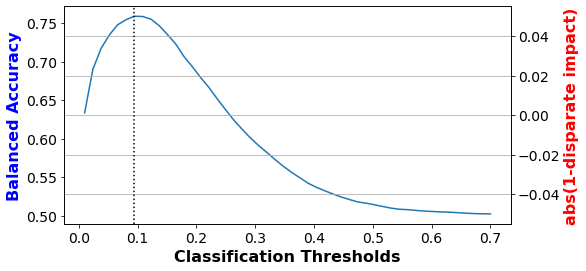

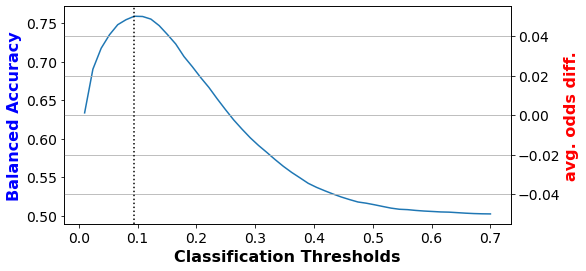

In [0]:
threshold_lr = validate_visualize(orig_validate,
                                  model_adapt.predict(model_adapt, orig_validate.features[:,:-cut_feat]))

In [0]:
values = validate_test(orig_test, model_adapt.predict(model_adapt, orig_test.features[:,:-cut_feat]),threshold_lr)

values["method"] = "lgb"
metrics_df = pd.DataFrame(columns=values.keys())
metrics_df = metrics_df.append(values, ignore_index=True)

Threshold corresponding to Best balanced accuracy: 0.0945
Best balanced accuracy: 0.7488
Corresponding abs(1-disparate impact) value: 0.0456
Corresponding average odds difference value: -0.0125
Corresponding statistical parity difference value: -0.0291
Corresponding equal opportunity difference value: -0.0082
Corresponding Theil index value: 0.3456


**Reweighing Preprocessing Technique**

It is best to start with preprocessing to mediate bias, and then to use post-processing, the earliest your can mediate it, the greatest level of flexibility is left in later stages for further correction. Among pre-processing algorithms, reweighing only changes weights applied to training samples; it does not change any feature or label values. Therefore, it may be a preferred option in case the application does not allow for value changes. Disparate impact remover and optimized pre-processing yield modified datasets in the same space as the input training data, whereas LFR’s pre-processed dataset is in a latent space.  If the application requires transparency on the transformation, then disparate impact remover and optimized pre-processing may be preferred options. Moreover, optimized pre-processing addresses both group fairness and individual fairness.

In [0]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(orig_train)
trans_train = RW.transform(orig_train)

metric_transf_train = BinaryLabelDatasetMetric(trans_train, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
print("#### Transformed training dataset")
print("Difference in mean outcomes between privileged and unprivileged groups = %f" % \
                                                  metric_transf_train.mean_difference())

X_train = trans_train.features[:,:-cut_feat]
y_train = trans_train.labels.ravel()
#X_train = np.append(X_train, trans_train.instance_weights.reshape(len(trans_train.instance_weights),1), axis=1)

d_train_org = lgb.Dataset(X_train, label=y_train, weight=trans_train.instance_weights)

if majority:
  sens_params = new_params
  mono_str_sens, _ = monotone(train, X_sens, y, constrained); print(mono_str_sens)
  sens_params["monotone_constraints"] = mono_str_sens
  model = lgb.train(sens_params, d_train_org, verbose_eval=1000)
else:
  model = lgb.train(best_params, d_train_org, verbose_eval=1000)

model_adapt= deepcopy(model)
model_adapt.predict =  predictclass


#### Transformed training dataset
Difference in mean outcomes between privileged and unprivileged groups = nan
1,0,0,-1,1,0,0,-1,0,1,0,0,0,0,0,0,0,0,0,0,0


100%|██████████| 50/50 [00:02<00:00, 19.64it/s]


Threshold corresponding to Best balanced accuracy: 0.1086
Best balanced accuracy: 0.7563
Corresponding abs(1-disparate impact) value:    nan
Corresponding average odds difference value:    nan
Corresponding statistical parity difference value:    nan
Corresponding equal opportunity difference value:    nan
Corresponding Theil index value: 0.3351


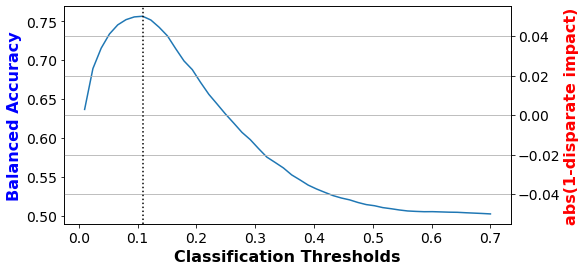

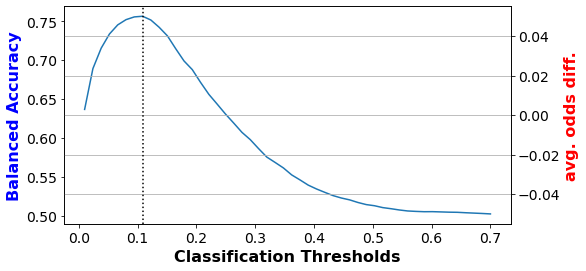

In [0]:
threshold_lr = validate_visualize(orig_validate,
                                  model_adapt.predict(model_adapt, orig_validate.features[:,:-cut_feat]))

In [0]:
values = validate_test(orig_test, model_adapt.predict(model_adapt, orig_test.features[:,:-cut_feat]),threshold_lr)

values["method"] = "lgb - Reweighting"
metrics_df = metrics_df.append(values, ignore_index=True)

Threshold corresponding to Best balanced accuracy: 0.1086
Best balanced accuracy: 0.7386
Corresponding abs(1-disparate impact) value: 0.0482
Corresponding average odds difference value: -0.0081
Corresponding statistical parity difference value: -0.0329
Corresponding equal opportunity difference value: -0.0158
Corresponding Theil index value: 0.2968


Optimized preprocessing is a preprocessing technique that learns a
    probabilistic transformation that edits the features and labels in the data
    with group fairness, individual distortion, and data fidelity constraints
    and objectives .Reject option classification is a postprocessing technique that gives
    favorable outcomes to unpriviliged groups and unfavorable outcomes to
    priviliged groups in a confidence band around the decision boundary with the
    highest uncertainty. Disparate impact remover is a preprocessing technique that edits feature
    values increase group fairness while preserving rank-ordering within groups.Learning fair representations is a pre-processing technique that finds a
    latent representation which encodes the data well but obfuscates information
    about protected attributes.

**Disparate Impact Preprocessing**

In [0]:
!pip3 install BlackBoxAuditing

In [0]:
tr_dataset = orig_train.copy(deepcopy=True)

di = DisparateImpactRemover(repair_level=1.0)
train_repd = di.fit_transform(tr_dataset) #repair training dataset
index = tr_dataset.feature_names.index(sens_attr)

X_tr = np.delete(train_repd.features, index, axis=1)
y_tr = train_repd.labels.ravel()

d_train_org = lgb.Dataset(X_tr, label=y_tr)
if majority:
  model_dir = lgb.train(sens_params, d_train_org, verbose_eval=1000)
else:
  model_dir = lgb.train(best_params, d_train_org, verbose_eval=1000)
## New monotonicty

model_adapt= deepcopy(model_dir)
model_adapt.predict =  predictclass

# meps_orig_dir_scale = scale
# meps_orig_dir = model_adapt

In [0]:
# train.head()

So clearly some values have been readjusted, the benefit is that these adjustment can still be communicated back to the applicant.

In [0]:
# pd.DataFrame(X_tr, columns=X).head()

100%|██████████| 50/50 [00:02<00:00, 20.30it/s]


Threshold corresponding to Best balanced accuracy: 0.1086
Best balanced accuracy: 0.7563
Corresponding abs(1-disparate impact) value:    nan
Corresponding average odds difference value:    nan
Corresponding statistical parity difference value:    nan
Corresponding equal opportunity difference value:    nan
Corresponding Theil index value: 0.3351


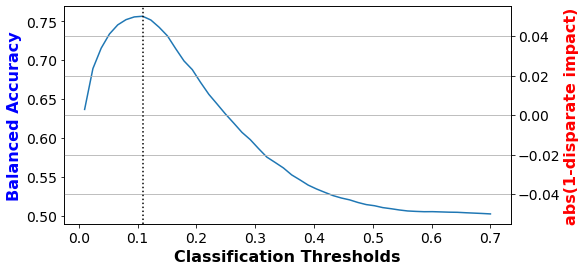

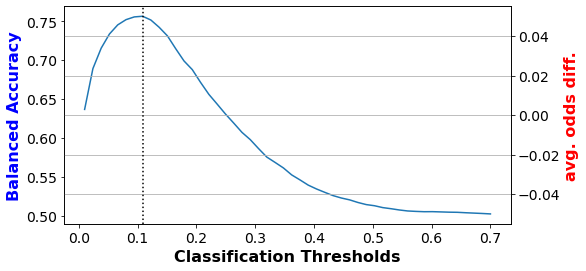

In [0]:
te_dataset= orig_validate.copy(deepcopy=True)

# te_dataset.features = meps_orig_dir_scale.transform(te_dataset.features)
validate_repd = di.fit_transform(te_dataset)  #repair validate dataset
X_te = np.delete(validate_repd.features, index, axis=1)
y_te_pred_prob = model_adapt.predict(model_adapt,X_te)

threshold_dir = validate_visualize(te_dataset,
                                   y_te_pred_prob)

In [0]:
te_dataset= orig_test.copy(deepcopy=True)
# te_dataset.features = meps_orig_dir_scale.transform(te_dataset.features)

test_repd = di.fit_transform(te_dataset)  #repair test dataset
X_te = np.delete(test_repd.features, index, axis=1)
y_te_pred_prob = model_adapt.predict(model_adapt, X_te)

values = validate_test(te_dataset,
                       y_te_pred_prob,
                       threshold_dir)
values["method"] = "lgb - Disparate Impact Remover"
metrics_df = metrics_df.append(values, ignore_index=True)

Threshold corresponding to Best balanced accuracy: 0.1086
Best balanced accuracy: 0.7306
Corresponding abs(1-disparate impact) value: 0.1116
Corresponding average odds difference value: 0.1300
Corresponding statistical parity difference value: 0.0708
Corresponding equal opportunity difference value: 0.0760
Corresponding Theil index value: 0.3399


**Calibrated Odds Postprocessing**

Changes predictions from a classifier to make them fairer. Provides favorable outcomes to unprivileged groups and unfavorable outcomes to privileged groups in a confidence band around the decision boundary with the highest uncertainty. Among post-processing algorithms, the two equalized odds post-processing algorithms have a randomized component whereas the reject option algorithm is deterministic, and may be preferred for that reason. 

In [0]:
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector
from aif360.algorithms.postprocessing.calibrated_eq_odds_postprocessing import CalibratedEqOddsPostprocessing
from tqdm import tqdm
cost_constraint = "fnr"

dataset_orig_valid_pred = orig_validate.copy(deepcopy=True)
y_valid_pred_prob = model.predict(orig_validate.features[:,:-cut_feat])
#y_valid_pred_prob = y_valid_pred_prob.reshape(-1,1)

dataset_orig_valid_pred.scores = y_valid_pred_prob

class_thresh = best_cut

y_valid_pred = np.zeros_like(dataset_orig_valid_pred.labels)
y_valid_pred[y_valid_pred_prob >= class_thresh] = dataset_orig_valid_pred.unfavorable_label
y_valid_pred[~(y_valid_pred_prob >= class_thresh)] = dataset_orig_valid_pred.favorable_label
dataset_orig_valid_pred.labels = y_valid_pred


# Learn parameters to equalize odds and apply to create a new dataset
cpp = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     cost_constraint=cost_constraint,
                                     seed=1)
cpp = cpp.fit(orig_validate, dataset_orig_valid_pred)

dataset_transf_test_pred = cpp.predict(orig_test)
pred_ceo = model_adapt.predict(model_adapt,orig_test.features[:,:-cut_feat])

100%|██████████| 50/50 [00:01<00:00, 28.73it/s]


Threshold corresponding to Best balanced accuracy: 0.0804
Best balanced accuracy: 0.7524
Corresponding abs(1-disparate impact) value: 0.0559
Corresponding average odds difference value: -0.0143
Corresponding statistical parity difference value: -0.0329
Corresponding equal opportunity difference value: -0.0122
Corresponding Theil index value: 0.4080


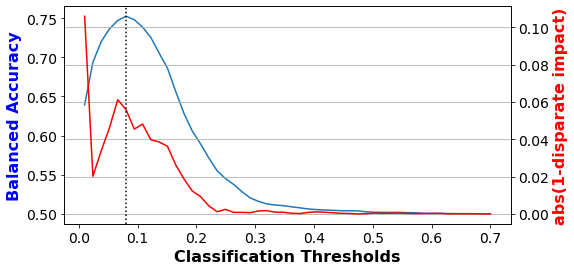

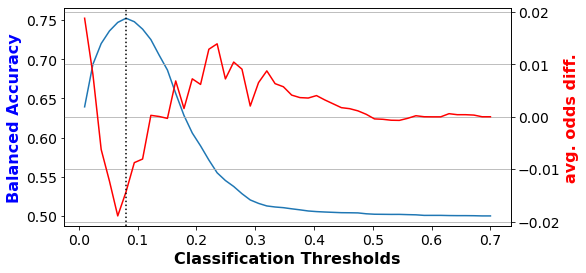

In [0]:
threshold_dir = validate_visualize(dataset_transf_test_pred,
                                   pred_ceo)

In [0]:
values = validate_test(dataset_transf_test_pred,
                       pred_ceo,
                       threshold_dir)
values["method"] = "lgb - Equal Odds Postprocessing"
metrics_df = metrics_df.append(values, ignore_index=True)

Threshold corresponding to Best balanced accuracy: 0.0804
Best balanced accuracy: 0.7524
Corresponding abs(1-disparate impact) value: 0.0559
Corresponding average odds difference value: -0.0143
Corresponding statistical parity difference value: -0.0329
Corresponding equal opportunity difference value: -0.0122
Corresponding Theil index value: 0.4080


All values should be close to zero or more than -0.20 for the protected group not to be too disadvantaged.

Mostly shows that all methods are fine. The majoritarian model might be a bit too aggressive. I had to run the notebook two times to get the different outcomes as outlines below.

In [0]:
#majoritarian model
metrics_df

,best_bal_acc,disp_imp,avg_odds_diff,stat_par_diff,eq_opp_diff,theil_ind,method
0,0.748819,0.045565,-0.012503,-0.029122,-0.008161,0.345580,lgb
1,0.738553,0.048156,-0.008062,-0.032900,-0.015769,0.296755,lgb - Reweighting
2,0.730623,0.111590,0.129957,0.070802,0.076024,0.339902,lgb - Disparate Impact Remover
3,0.752449,0.055860,-0.014326,-0.032920,-0.012239,0.408015,lgb - Equal Odds Postprocessing


In [0]:
#original model
metrics_df

,best_bal_acc,disp_imp,avg_odds_diff,stat_par_diff,eq_opp_diff,theil_ind,method
0,0.753388,0.067881,-0.024478,-0.040315,-0.018641,0.403117,lgb
1,0.752138,0.063645,-0.019975,-0.037531,-0.016553,0.408521,lgb - Reweighting
2,0.747261,0.023941,0.024545,0.013616,0.036421,0.428373,lgb - Disparate Impact Remover
3,0.748077,0.072983,-0.035886,-0.046139,-0.023199,0.357377,lgb - Equal Odds Postprocessing


#### **Feature Decomposition**

Here our primary focus is on the equity doctrine and looking at the structural biases by decomposing the features. Decomposing quantitative fairness metrics using SHAP can reduce their opacity when the metrics are driven by measurement biases effecting only a few features.

The original half-mono LightGBM model is going to be used because it's performance on the fairness metrics is reasonable. Let's retrain the model here. 

In [0]:
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")

auc_perf = {}
d_train = lgb.Dataset(train[X], label=train[y])
d_test = lgb.Dataset(test[X], label=test[y])
model = lgb.train(best_params, d_train, verbose_eval=1000)
y_pred_test = model.predict(test[X])
perf = roc_auc_score(test[y], y_pred_test)
auc_perf["half-mono"] = perf
print('ROC AUC {}'.format(perf))

ROC AUC 0.8142107147766557


In [176]:
# build explanation
import shap
explainer = shap.TreeExplainer(model, shap.sample(test[X], 300))
shap_values = explainer.shap_values(test[X])

100%|===================| 39616/39662 [08:02<00:00]       

In [0]:
model_outputs_A = explainer.expected_value + shap_values.sum(1)
glabel = "Demographic parity difference\nof model output for non-white vs. white"
xmin = -0.8
xmax = 0.8
#shap.group_difference_plot(shap_values.sum(1), test_org["white"], xmin=xmin, xmax=xmax, xlabel=glabel)

In [0]:
test_a = test_org.fillna(test_org.mode().iloc[0]).reset_index()
test_a = test_a.astype(int)

In [0]:
unpri = test_a[test_a["white"]==0].index.to_list()
unpri_shap = shap_values[unpri, :].mean(0).reshape(len(X), 1)

In [0]:
priv = test_a[test_a["white"]==1].index.to_list()
priv_shap = shap_values[priv, :].mean(0).reshape(len(X), 1)

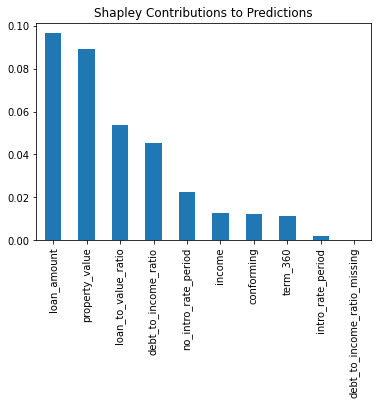

In [183]:
s_df = pd.DataFrame(unpri_shap, columns=['Reason Codes'], index=X)
s_df = s_df.abs()
_ = s_df.sort_values(by='Reason Codes', ascending=False).plot(kind='bar', legend=False, 
                                                              title='Shapley Contributions to Predictions')
# check that Shapley is locally accurate

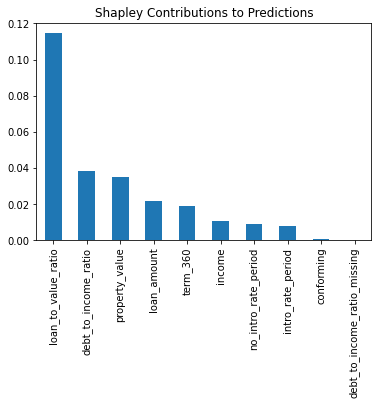

In [184]:
s_df = pd.DataFrame(priv_shap, columns=['Reason Codes'], index=X)
s_df = s_df.abs()
_ = s_df.sort_values(by='Reason Codes', ascending=False).plot(kind='bar', legend=False, 
                                                              title='Shapley Contributions to Predictions')
# check that Shapley is locally accurate

What does the privlidged group have that contirbutes more off and less off to the final prediction. You could also incude the sensitive features and see if the order of importance change. If the relative importance change, it could be evidence of a biased variable.

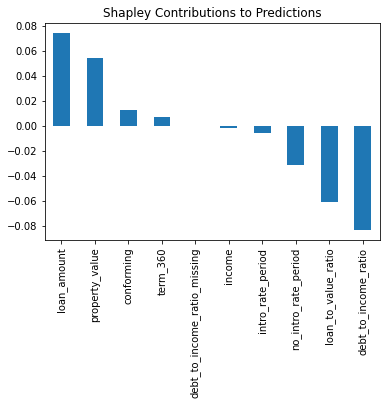

In [185]:
s_df = pd.DataFrame(priv_shap - unpri_shap, columns=['Reason Codes'], index=X)
_ = s_df.sort_values(by='Reason Codes', ascending=False).plot(kind='bar', legend=False, 
                                                              title='Shapley Contributions to Predictions')
# check that Shapley is locally accurate



*Train model with sensitive features:*

In [169]:
# build explanation
import shap
explainer = shap.TreeExplainer(model_sens, shap.sample(test[X_sens], 300))
shap_values_sens = explainer.shap_values(test[X_sens])

100%|===================| 39655/39662 [07:39<00:00]       

In [173]:
X_sens

['term_360',
 'conforming',
 'debt_to_income_ratio_missing',
 'loan_amount',
 'loan_to_value_ratio',
 'no_intro_rate_period',
 'intro_rate_period',
 'property_value',
 'income',
 'debt_to_income_ratio',
 'asian',
 'black',
 'white',
 'amind',
 'hipac',
 'hispanic',
 'non_hispanic',
 'male',
 'female',
 'above62',
 'below62']

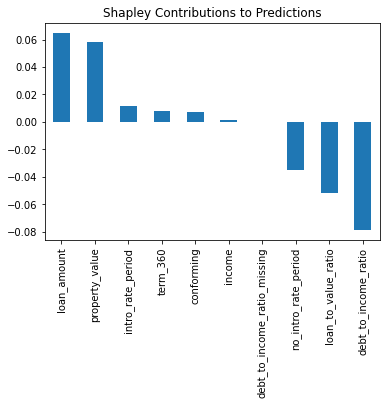

In [175]:
unpri_shap = shap_values_sens[unpri, :].mean(0).reshape(len(X_sens), 1)
priv_shap = shap_values_sens[priv, :].mean(0).reshape(len(X_sens), 1)
s_df_sens = pd.DataFrame(priv_shap - unpri_shap, columns=['Reason Codes'], index=X_sens).T[X].T
_ = s_df_sens.sort_values(by='Reason Codes', ascending=False).plot(kind='bar', legend=False, 
                                                              title='Shapley Contributions to Predictions')

*Biased Variables*

Conforming and the loan amount has become less important when the demographic variables are included as conditioned from the most important variable (debt to income). Meaning that some of the demographic variables were picked up in those values. The chart above therefore removes all superficial demographical characteristics and only rely on the structural feature differences between groups.

In [188]:
(s_df_sens.abs()/s_df_sens.abs().max()) - (s_df.abs()/s_df.abs().max())

,Reason Codes
term_360,0.014226
conforming,-0.064229
debt_to_income_ratio_missing,0.000000
loan_amount,-0.069802
loan_to_value_ratio,-0.070300
no_intro_rate_period,0.066342
intro_rate_period,0.071094
property_value,0.086517
income,-0.006048
debt_to_income_ratio,0.000000


### **Individual Level**

#### **Reasoning**

**Individual Disparity**

In [0]:
# Two Types
y_hat = y +"_pred"
test_yhat = test_org.copy()
test_yhat[y_hat] = y_pred_test

prauc_frame = get_prauc(test_yhat, y, y_hat)
best_cut = prauc_frame.loc[prauc_frame['f1'].idxmax(), 'cutoff'] # Find cutoff w/ max F1

characteristic = "white"
test_res = test_yhat.copy()
test_res['s'] = 1
test_res.loc[test_res[y] == 0, 's'] = -1
resid_dr = y + "_resdr"
test_res[resid_dr] = test_res['s'] * np.sqrt(-2*(test_res[y]*np.log(test_res[y_hat]) +
                                                                 ((1 - test_res[y])*np.log(1 - test_res[y_hat]))))
test_res = test_res.drop('s', axis=1)
resid_ll = y + '_resll' 
test_res[resid_ll] = -test_res[y]*np.log(test_res[y_hat]) -\
                       (1 - test_res[y])*np.log(1 - test_yhat[y_hat]) 

# non-white data frame
test_yhat_protect = test_res[test_res[characteristic] == 0].copy(deep=True)
test_yhat_protect[y_hat+ '_binary'] = 0
test_yhat_protect.loc[test_yhat_protect[y_hat] > best_cut, y_hat+ '_binary'] = 1  

In [0]:
test_yhat_protect = test_yhat_protect[(test_yhat_protect[y] == 0) &\
                                       (test_yhat_protect[y_hat+ '_binary'] == 1)]

In [0]:
## Top three outlying indviduals
test_yhat_protect.sort_values(by=y +'_resll', ascending=False).head(3)

,default,term_360,conforming,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,above62,below62,debt_to_income_ratio_missing,loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,debt_to_income_ratio,default_pred,default_resdr,default_resll,default_pred_binary
id,,,,,,,,,,,,,,,,,,,,,,,,,,
1600892,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,0.0,1.0,0.0,-0.470459,0.552734,-4.089844,2.197266,-0.536133,-0.028183,1.585938,0.763901,-1.699119,1.443502,1
1682197,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,-1.085938,0.552734,0.244385,-0.215332,-0.967773,-0.045502,1.585938,0.733259,-1.625716,1.321477,1
1622753,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,-1.041992,0.552734,0.244385,-0.215332,-0.937012,-0.042389,1.585938,0.676202,-1.501755,1.127634,1


**Reasoning Codes**

Anyone that is denied further credit due to this model in the U.S. must be given reasons why. It is clear that intro rate period should be given more attention.

Sum of Shapley contributions and bias: 3.227248074791011
Model prediction in margin space: 1.174184676990749


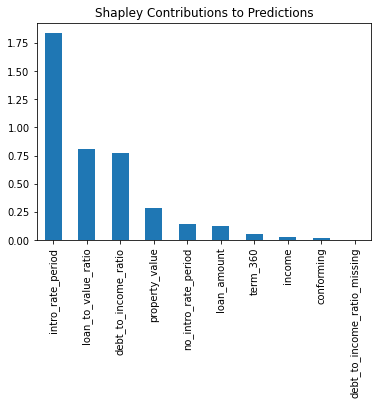

In [0]:
# select highest residual non-white false positive
indiv = test_yhat_protect.sort_values(by=resid_ll, ascending=False).head(n=1)

# search for her index in shap_values array
# create Pandas DataFrame and plot
loc = test_org.index.get_loc(indiv.index[0])
s_df = pd.DataFrame(shap_values[loc, :].reshape(len(X), 1), columns=['Reason Codes'], index=X)
s_df = s_df.abs()
_ = s_df.sort_values(by='Reason Codes', ascending=False).plot(kind='bar', legend=False, 
                                                              title='Shapley Contributions to Predictions')
# check that Shapley is locally accurate
# you have to check on this calc again
print('Sum of Shapley contributions and bias:', s_df.sum()[0] + shap_values[0, -1])
print('Model prediction in margin space:', np.log(indiv[y_hat].values/(1 - indiv[y_hat].values))[0])

In [0]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[loc,:], test[X].iloc[loc,:])

#### **Example Based**

**Prototypical Explanations**

Examples in the database most like a sample given. A way to see if the ample was treated unfairly or different.

In [0]:
!pip install aix360

     |████████████████████████████████| 10.7MB 1.4MB/s 
     |████████████████████████████████| 276kB 37.4MB/s 
     |████████████████████████████████| 109.2MB 63kB/s 
     |████████████████████████████████| 491kB 46.7MB/s 
     |████████████████████████████████| 3.2MB 26.6MB/s 
  Created wheel for lime: filename=lime-0.1.1.37-cp36-none-any.whl size=284277 sha256=f57755451b5e8b5435aa453d3e7da60c76b68d27d3589c360b5a857b60a0a936
  Stored in directory: /root/.cache/pip/wheels/c1/38/e7/50d75d4fb75afa604570dc42f20c5c5f5ab26d3fbe8d6ef27b
  Created wheel for progressbar: filename=progressbar-2.5-cp36-none-any.whl size=12074 sha256=867c812127c474675c6938268ef4e10091403eb8b0f4bdd9e2cd3a48451d5ee1
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built lime progressbar
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator

In [0]:
from aix360.algorithms.protodash import ProtodashExplainer

In [0]:
explainer = ProtodashExplainer()
inds = test_yhat_protect.sort_values(by=resid_ll, ascending=False).head(n=10)
(W, S, setValues) = explainer.explain(inds[X].values,test_yhat_protect[X].values, m=10)

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -2.0000e+04  4e+00  1e+00  1e+00
 1:  5.6141e+00 -1.3850e+05  2e+01  1e+00  1e+00
 2:  5.9004e+01 -1.7625e+06  4e+02  1e+00  1e+00
 3:  9.1949e+01 -3.7042e+06  1e+03  1e+00  1e+00
 4:  4.1903e+01 -1.5830e+07  3e+03  1e+00  1e+00
 5:  7.8071e+00 -1.0380e+08  2e+04  1e+00  1e+00
 6:  2.0428e+01 -5.4873e+09  1e+06  1e+00  1e+00
 7:  3.6239e+08 -1.3348e+17  1e+17  7e-13  3e-03
 8:  3.6239e+08 -1.3348e+15  1e+15  7e-15  4e-05
 9:  3.6239e+08 -1.3350e+13  1e+13  2e-16  1e-06
10:  3.6223e+08 -1.3467e+11  1e+11  2e-16  2e-08
11:  3.4783e+08 -2.6238e+09  3e+09  5e-17  2e-10
12:  1.7877e+08 -1.7573e+09  2e+09  3e-16  3e-08
13:  4.6984e+07 -2.6198e+08  3e+08  2e-16  4e-09
14:  1.8871e+08 -4.5006e+08  6e+08  4e-17  2e-09
15:  1.0605e+08 -1.6174e+08  3e+08  2e-16  3e-10
16:  1.3558e+07 -8.6731e+07  1e+08  7e-16  7e-13
17:  3.3520e+06 -4.6348e+06  8e+06  5e-17  1e-12
18:  4.8743e+05 -5.4539e+05  1e+06  2e-16  2e-13
19:  6.9911e+04 -7.85

In [0]:
indas = inds[X +[y_hat]].T.mean(axis=1)

In [0]:
prt = test_yhat.iloc[S,:]
prots = (prt[X +[y_hat]].T*W).sum(axis=1)

It is comforting to know that the top prototype would get the same predicted outcome. So this indivdual is not entirely unfairly treated. They also have higher debt to income and lower income than the prototype so the differences in the default prediction also seems intuitive.

In [0]:
df = pd.DataFrame([inds[X+[y_hat]].iloc[0],prt[X+[y_hat]].iloc[0],indas[X+[y_hat]], prots[X+[y_hat]]])
df =df.T
df.columns = ["Query Individual", "Top Prototype Example", "Average Query Individual","Weighted Average Prototype"]; df

,Query Individual,Top Prototype Example,Average Query Individual,Weighted Average Prototype
term_360,1.000000,1.000000,1.000000,0.829540
conforming,1.000000,1.000000,1.000000,1.015444
debt_to_income_ratio_missing,0.000000,0.000000,0.000000,0.000000
loan_amount,-0.470459,-0.558594,-0.883716,-0.565262
loan_to_value_ratio,0.552734,0.321533,0.552734,0.218675
no_intro_rate_period,-4.089844,-4.089844,-0.622461,-2.183343
intro_rate_period,2.197266,3.162109,0.267188,1.676087
property_value,-0.536133,-0.566895,-0.825830,-0.564377
income,-0.028183,0.196655,-0.039336,0.098087
debt_to_income_ratio,1.585938,-2.527344,1.110580,-0.935354


**Counterfactual Explanations**

Simply answers what should be minimally changed to change the prediction. What should be changed to go from a default to a no-default prediction.

In [0]:
!pip install alibi

In [0]:
from copy import deepcopy

def predictclass(self, data, thresh, num_iteration=None,
                raw_score=False, pred_leaf=False, pred_contrib=False,
                data_has_header=False, is_reshape=True, **kwargs):
        predictor = self._to_predictor(copy.deepcopy(kwargs))
        if num_iteration is None:
            num_iteration = self.best_iteration
        ta = predictor.predict(data, num_iteration,
                                 raw_score, pred_leaf, pred_contrib,
                                 data_has_header, is_reshape)
        
        ta = np.where(ta<thresh, ta/thresh/2, ta/2+0.5)

        return np.vstack(((1-ta),ta)).T

model_adapt= deepcopy(model)
model_adapt.predict =  predictclass
ra = model_adapt.predict(model_adapt,train[X].values, best_cut); ra.shape

(160338, 2)

In [0]:
# from copy import deepcopy

# def predictclass(self, data, num_iteration=None,
#                 raw_score=False, pred_leaf=False, pred_contrib=False,
#                 data_has_header=False, is_reshape=True, **kwargs):
#         predictor = self._to_predictor(copy.deepcopy(kwargs))
#         if num_iteration is None:
#             num_iteration = self.best_iteration
#         ta = predictor.predict(data, num_iteration,
#                                  raw_score, pred_leaf, pred_contrib,
#                                  data_has_header, is_reshape)
        

#         return np.vstack(((1-ta),ta)).T


# model_adapt= deepcopy(model)
# model_adapt.predict =  predictclass
# ra = model_adapt.predict(model_adapt,train[X].values); ra.shape

(160338, 2)

In [0]:
test = test.fillna(test.median())
train = train.fillna(train.median())

In [0]:
### You can use auto-encoder with a different prediction .
# https://github.com/SeldonIO/alibi/issues/170
from alibi.explainers import CounterFactualProto
import copy

protect = test_yhat_protect.sort_values(by=y +'_resll', ascending=False).head(1)
row_protect = test[X].loc[protect.index,:].iloc[0].values.reshape((1,) + test[X].loc[protect.index,:].iloc[0].values.shape)

shape = row_protect.shape
# shape = (1,) + train.shape[1:]

predict_fn = lambda x: model_adapt.predict(model_adapt,x, best_cut)

# eps=(0.05, 0.05), I added this, but obtains worse counterfactuals. 
cf = CounterFactualProto(predict_fn, shape, use_kdtree=True,eps=(0.05, 0.05), theta=10., feature_range=(train[X].min(axis=0), train[X].max(axis=0)))
cf.fit(train[X].values, trustscore_kwargs=None)
explanation = cf.explain(row_protect, k=2)

No encoder specified. Using k-d trees to represent class prototypes.


In [0]:
counterfactual = explanation['cf']['X']

In [0]:
delta = counterfactual - row_protect; delta

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.10066724, 0.        , 0.        , 0.        ]],
      dtype=float32)

Counterfactual has a higher intro_rate period. This intro rate period can significantly affect whether or not the classification changes. This means it contains hidden information that should be uncovered. 

In [0]:
## https://docs.seldon.io/projects/alibi/en/stable/examples/cfproto_housing.html
## Ordinal one  - https://docs.seldon.io/projects/alibi/en/stable/examples/cfproto_cat_adult_ord.html
## To not default the following is nesary 

for i, f in enumerate(X):
    if np.abs(delta[0][i]) > 1e-4:
        print('{}: {}'.format("original "+ f, row_protect[0][i]))
        print('{}: {}'.format("counterfactual "+ f, counterfactual[0][i]))
        print('{}: {}'.format("difference "+ f, delta[0][i]))

original intro_rate_period: 2.197265625
counterfactual intro_rate_period: 2.2979328632354736
difference intro_rate_period: 0.10066723823547363


In [0]:
model.predict(counterfactual)

array([0.13753288])

In [0]:
model.predict(row_protect)

array([0.76390058])

**Constrastive Explanations**

*Pertinent Negative*

PN identifies what features should be minimally and necessarily absent from the instance to be explained in order to maintain the original prediction class. The aim of PN’s is not to provide a full set of characteristics that should be absent in the explained instance, but to provide a minimal set that differentiates it from the closest different class. Here it gives the same result as the counterfactual.

In [0]:
from alibi.explainers import CEM

mode = 'PN'
# initialize CEM explainer and explain instance
cem = CEM(predict_fn, mode, shape,eps=(0.05, 0.05), feature_range=(train[X].min(axis=0), train[X].max(axis=0)))
cem.fit(train[X].values, no_info_type='median')
explanation = cem.explain(row_protect, verbose=False)

In [0]:
print('Original instance: {}'.format(explanation.X))
print('Predicted class: {}'.format(explanation.X_pred))

Original instance: [[ 1.       1.       0.      -0.4705   0.5527  -4.09     2.197   -0.536
  -0.02818  1.586  ]]
Predicted class: 1


In [0]:
print('Pertinent negative: {}'.format(explanation.PN))
print('Predicted class: {}'.format(explanation.PN_pred))

Pertinent negative: [[ 1.          1.          0.         -0.47045898  0.5527344  -4.0898438
   2.297929   -0.5361328  -0.02818298  1.5859375 ]]
Predicted class: 0


In [0]:
delta_pn = explanation.PN - row_protect; delta_pn

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.10066342, 0.        , 0.        , 0.        ]],
      dtype=float32)

In [0]:
for i, f in enumerate(X):
    if np.abs(delta[0][i]) > 1e-4:
        print('{}: {}'.format("original "+ f, row_protect[0][i]))
        print('{}: {}'.format("pertinent negative "+ f, explanation.PN[0][i]))
        print('{}: {}'.format("difference "+ f, delta_pn[0][i]))

original intro_rate_period: 2.197265625
pertinent negative intro_rate_period: 2.297929048538208
difference intro_rate_period: 0.10066342353820801


In [0]:
model.predict(explanation.PN )

array([0.13753288])

**Pertinent Positive**

For a pertinent positive (PP), the method finds the features that should be minimally and sufficiently present (e.g. important pixels in an image) to predict the same class as on the original instance.

In [0]:
row_protect

array([[ 1.     ,  1.     ,  0.     , -0.4705 ,  0.5527 , -4.09   ,
         2.197  , -0.536  , -0.02818,  1.586  ]], dtype=float16)

In [0]:
mode = 'PP'
# initialize CEM explainer and explain instance
cem = CEM(predict_fn, mode, shape,eps=(0.5, 0.5), feature_range=(train[X].min(axis=0), train[X].max(axis=0)))
cem.fit(train[X].values, no_info_type='median')
explanation = cem.explain(row_protect, verbose=False)

No PP found!


In [0]:
print('Pertinent positive: {}'.format(explanation.PP))
print('Predicted class: {}'.format(explanation.PP_pred))

Pertinent positive: None
Predicted class: None
